<a href="https://colab.research.google.com/github/Ilvecho/Project_7/blob/main/Project_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data available for this project are **real data** so they are dirty.

A lot of values are missing, so we need to think how to handle them.

Normally, several hypothesis need to be tested, but in this case we are short in time, so we would make just one iteration of reasonable assumptions.

Furthermore, the data contains the **date** of each step, as well as the date of first and last contact.

We will leverage these pieces of information mainly to fill out some missing values. However, for the model itself we will just consider the binary state (yes - no) rather than the dates. This choice is driven by the need to prioritize simplicity for time constraints.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle
import re
import random

import torch
from torch import nn
from torch import flatten
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

from google.colab import files,drive
drive.mount('/content/gdrive')

# get the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load data & preliminary operations

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/P7_files/SalesCRM - CRM.csv')

In [ ]:
data.shape

(11032, 13)

In [ ]:
for col in data.columns:
  print(col)

ID
Country
Education
First Contact
Last Contact
Status
Stage
First Call
Signed up for a demo
Filled in customer survey
Did sign up to the platform
Account Manager assigned
Subscribed


In [ ]:
rel_cols = data.drop(columns=['ID', 'Country', 'Education'])
nan_rows = data[rel_cols.isna().all(axis=1)]
nan_rows

,ID,Country,Education,First Contact,Last Contact,Status,Stage,First Call,Signed up for a demo,Filled in customer survey,Did sign up to the platform,Account Manager assigned,Subscribed
125,126,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,278,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's delete the empty rows: they give no added value

In [ ]:
# Many of the cells have value NaN. Let's replace it with a different value so that we are able to count the number of NaN's as well
parsed_data = data[~rel_cols.isna().all(axis=1)].copy()

# Fill the NaN
parsed_data['Country'] = parsed_data['Country'].fillna('missing')
parsed_data['Education'] = parsed_data['Education'].fillna('missing')
parsed_data['Status'] = parsed_data['Status'].fillna('missing')
parsed_data['Stage'] = parsed_data['Stage'].fillna('missing')


parsed_data.set_index('ID', inplace=True)

# Date features parsing

All the other features represent a date in time, so we need convert the columns to **datetime format**.

Let's define a parser function

In [ ]:
# define the datetime parser function
def datetime_parser(column):

  # Iterate through all the rows, because different rows can have different datetime patterns
  for i in list(column.index):

    # Define the patterns observed in the data
    pattern_1 = re.compile(r'^[0-9]{4}\-[0-9]{2}\-[0-9]{4}$')
    pattern_2 = re.compile(r'^[0-9]{2}\.[0-9]{2}\.[0-9]{4}$')
    pattern_3 = re.compile(r'^[0-9]{2}\-[0-9]{2}\-[0-9]{4}$')

    # If the row is already in Datetime format, pass
    if isinstance(column.loc[i], pd.Timestamp):
      pass

    # If the value is missing, assign Not a Time
    elif pd.isna(column.loc[i]):
      column.loc[i] = pd.NaT

    # If the string matches the first patter, convert accordingly
    elif pattern_1.match(column.loc[i]):
      column.loc[i] = pd.to_datetime(column.loc[i], format='%Y-%m-%d')

    # If the string matches the second patter, convert accordingly
    elif pattern_2.match(column.loc[i]):
      column.loc[i] = pd.to_datetime(column.loc[i], format='%d.%m.%Y')

    # If the string matches the third patter, we are still not sure about the format
    elif pattern_3.match(column.loc[i]):
      # So, try one format and catch exceptions and use the other possible format
      try:
        column.loc[i] = pd.to_datetime(column.loc[i], format='%d-%m-%Y')
      except:
        column.loc[i] = pd.to_datetime(column.loc[i], format='%m-%d-%Y')

  return pd.to_datetime(column)

Manually fix an exception

In [ ]:
# There is one row that has format Y-d-m rather then Y-m-d
idx = parsed_data[parsed_data['First Contact'] == '2021-13-12'].index
parsed_data['First Contact'].loc[idx] = "2021-12-13"
parsed_data['Last Contact'].loc[idx] = "2021-12-13"

Parse the **First Contact** column

In [ ]:
parsed_data['First Contact'] = datetime_parser(parsed_data['First Contact'])

Parse the **Last Contact** column

In [ ]:
parsed_data['Last Contact'] = datetime_parser(parsed_data['Last Contact'])

<ipython-input-31-3cadf41cfe05>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.NaT
<ipython-input-31-3cadf41cfe05>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.to_datetime(column.loc[i], format='%d.%m.%Y')
<ipython-input-31-3cadf41cfe05>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.to_datetime(column.loc[i], format='%m-%d-%Y')


Parse the **First Call** column

In [ ]:
parsed_data['First Call'] = datetime_parser(parsed_data['First Call'])

<ipython-input-31-3cadf41cfe05>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.NaT


Parse the **Signed up for a demo** column

In [ ]:
parsed_data['Signed up for a demo'] = datetime_parser(parsed_data['Signed up for a demo'])

<ipython-input-31-3cadf41cfe05>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.NaT


Parse the **Filled in customer survey** column

In [ ]:
parsed_data['Filled in customer survey'] = datetime_parser(parsed_data['Filled in customer survey'])

<ipython-input-31-3cadf41cfe05>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.NaT


Parse the **Did sign up to the platform** column.

Actually we notice that some cells in this column do not contain a datetime value, but rather the string "No"

In [ ]:
mask = (parsed_data['Did sign up to the platform'] == 'No')
did_not_signed = parsed_data[mask]
did_not_signed['First Call'].isna().sum()

0

Looking at the "First Call" column of these rows, we notice that in **all cases** the first call happened and the potential customer decided not to Sign up to the platform. Hopefully our model will be able to pick up this trend.

Now we need to remove the 'No' values from the column, but we stil want to preserve the information.

Let's create a **new boolean feature**

In [ ]:
# first let's rename the original column
parsed_data.rename(columns={'Did sign up to the platform': 'Date Platform sign up'}, inplace=True)
# Create the new column
parsed_data['Bool Platform sign up'] = np.nan

# Create a mask to find the rows where Customer actually did signed up
signed_mask = (parsed_data['Date Platform sign up'].notna()) & (parsed_data['Date Platform sign up'] != 'No')
parsed_data['Bool Platform sign up'][signed_mask] = 1

# Create a mask for the rows where we know that customer DID NOT signed up
not_signed_mask = (parsed_data['Date Platform sign up'] == 'No')
parsed_data['Bool Platform sign up'][not_signed_mask] = -1

<ipython-input-39-a5bf1bc4ebba>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_data['Bool Platform sign up'][signed_mask] = 1
<ipython-input-39-a5bf1bc4ebba>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_data['Bool Platform sign up'][not_signed_mask] = -1


Now we can actually proceed to parsing the column 'Date Platform sign up'

In [ ]:
parsed_data['Date Platform sign up'] = parsed_data['Date Platform sign up'].replace('No', pd.NaT)

# When running the parser we notice that one cell has a typo in the year: 20221
# let's find the row and fix the issue
idx = np.where(parsed_data['Date Platform sign up'] == '20221-08-24')
parsed_data['Date Platform sign up'].iloc[idx] = '2021-08-24'

<ipython-input-40-4868518e71eb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_data['Date Platform sign up'].iloc[idx] = '2021-08-24'


In [ ]:
# Finally parse the column
parsed_data['Date Platform sign up'] = datetime_parser(parsed_data['Date Platform sign up'])

<ipython-input-31-3cadf41cfe05>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.NaT


In [ ]:
parsed_data['Account Manager assigned'] = datetime_parser(parsed_data['Account Manager assigned'])

<ipython-input-31-3cadf41cfe05>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.NaT


In [ ]:
# Also column "subscribed" has an unexpected value - we need to manually modify it
idx = np.where(parsed_data['Subscribed'] == '0000-00-00')
parsed_data['Subscribed'].iloc[idx] = pd.NaT

<ipython-input-43-5284ecdf84cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_data['Subscribed'].iloc[idx] = pd.NaT


In [ ]:
parsed_data['Subscribed'] = datetime_parser(parsed_data['Subscribed'])

<ipython-input-31-3cadf41cfe05>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[i] = pd.NaT


In [ ]:
parsed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11028 entries, 1 to 11793
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Country                    11028 non-null  object        
 1   Education                  11028 non-null  object        
 2   First Contact              10317 non-null  datetime64[ns]
 3   Last Contact               10722 non-null  datetime64[ns]
 4   Status                     11028 non-null  object        
 5   Stage                      11028 non-null  object        
 6   First Call                 441 non-null    datetime64[ns]
 7   Signed up for a demo       283 non-null    datetime64[ns]
 8   Filled in customer survey  184 non-null    datetime64[ns]
 9   Date Platform sign up      296 non-null    datetime64[ns]
 10  Account Manager assigned   71 non-null     datetime64[ns]
 11  Subscribed                 47 non-null     datetime64[ns]
 12  Bool

# Exploratory Data Analysis - Country

In [ ]:
# Bar plot for the counties
fig = px.bar(
    parsed_data,
    x=parsed_data.groupby('Country').size().values,
    y=parsed_data.groupby('Country').size().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Country',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

I did not expect these many values for the country. Let's analyze this more in details:

In [ ]:
parsed_data['Country'].value_counts()

USA                         6604
missing                      889
Canada                       815
France                       336
UK                           329
                            ... 
uSA                            1
Hong Kong                      1
Singapore                      1
Cameroon                       1
Central African Republic       1
Name: Country, Length: 104, dtype: int64

There are **104** different Country values.
Actually there are some typos (e.g. uSA), so let's elaborate a bit the strings to get a more informative overview

In [ ]:
countries = parsed_data['Country'].str.rstrip().str.lower()
countries.value_counts()

usa                         6641
missing                      889
canada                       816
france                       336
uk                           331
                            ... 
full time                      1
bulgaria                       1
senegal                        1
jordan                         1
central african republic       1
Name: Country, Length: 94, dtype: int64

The modification showed indeed some typos. \

We also added a **rstrip** function to remove trailing spaces.

The new count is **94**

In [ ]:
countries.value_counts().tail(30)

bolivia                     2
kenya                       2
malaysia                    2
sri lanka                   2
philadelphia                1
congo                       1
california                  1
czechia                     1
russia&ukraine              1
nottingham                  1
korea                       1
bulgaria & uk               1
vietnamese                  1
greek                       1
romania                     1
turkey                      1
latvia                      1
hong kong                   1
seoul                       1
venezuela                   1
chuang                      1
benin                       1
guinea                      1
cameroon                    1
serbia                      1
full time                   1
bulgaria                    1
senegal                     1
jordan                      1
central african republic    1
Name: Country, dtype: int64

Looking at the tail, we still notice some duplicates (non compehensive list):
- Czechia is mentioned twice
- Bulgaria
- Nottingham is a city, not a country. Same is true for Seul, philadelphia and california
- Vietnamese is not a country
- Full time is not a country

Hence, let's create a lookup table to pre-process the country column

In [ ]:
lookup_table = {
    "nottingham": "uk",
    "seoul": "south korea",
    "greek": "greece",
    "vietnamese": "vietnam",
    "bulgaria & uk": "bulgaria",
    "korea": "south korea",
    "russia&ukraine": "russia",
    "california": "usa",
    "philadelphia": "usa",
    "ca": "usa",
    'england': "uk",
    "dubai": "united arab emirates",
    "czechia (czech republic)": "czechia",
    "chuang": "china",
    "-": "missing"
}

In [ ]:
countries = countries.apply(lambda x: lookup_table[x] if x in lookup_table.keys() else x)
countries.value_counts()

usa                         6645
missing                      899
canada                       816
france                       336
uk                           334
                            ... 
benin                          1
cameroon                       1
full time                      1
turkey                         1
central african republic       1
Name: Country, Length: 79, dtype: int64

Now we have **79** unique values

In [ ]:
parsed_data['Country'] = countries.copy()

# Bar plot for the counties
fig = px.bar(
    parsed_data,
    x=countries.value_counts(),
    y=countries.value_counts().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Country',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

The feature 'Country' will be part of the **state**:

we will **one-hot encode** the countries to obtain the first part of the state vector (size 79).

Note that this part of the state **cannot be changed** by any of the actions: it is a bio information

In [ ]:
idx = np.where(parsed_data['Country'] == 'missing')
print(f'Percentage of Missing values in Column Country: {idx[0].shape[0]/parsed_data.shape[0] * 100 :.2f} %')

Percentage of Missing values in Column Country: 8.15 %


All the rows of this column must have a value - the value 'Missing' does not make sense.

Since we have no additional information, we decide to fill out the missing values with the **10 most observed categories** in the observed proportion.

In [ ]:
# Select the top 10 observed categories
top_categories = parsed_data['Country'].value_counts().nlargest(10).index

# Filter the data to include only the top 10 categories
parsed_data_top_categories = parsed_data[parsed_data['Country'].isin(top_categories)]
# Drop the Missing
parsed_data_top_categories = parsed_data_top_categories[parsed_data_top_categories['Country'] != 'missing']

missing_values_count = idx[0].shape[0]

# Replace 'Missing' values using observed categories in proportion (top 10)
replacement_values = parsed_data_top_categories['Country'].sample(
    n=missing_values_count,
    replace=True,
    weights=parsed_data_top_categories.groupby('Country')['Country'].transform('count')
).values

# Replace the missing values
parsed_data['Country'].iloc[idx[0]] = replacement_values

# Bar plot for the counties
fig = px.bar(
    parsed_data,
    x=parsed_data['Country'].value_counts(),
    y=parsed_data['Country'].value_counts().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Country',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

<ipython-input-54-f55ed61685ec>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Exploratory Data Analysis - Education

In [ ]:
# Bar plot for the counties
fig = px.bar(
    parsed_data,
    x=parsed_data.groupby('Education').size().values,
    y=parsed_data.groupby('Education').size().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Education',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

the education category has a limited number of options - good.

Still important to notice that a lot of samples have value **missing**.

In [ ]:
parsed_data['Education'].value_counts()

missing    3599
B27        1942
B11         923
B10         670
B9          635
B1          393
B29         353
B21         331
B17         227
B14         218
B30         218
B16         213
B19         168
B28         132
B8          129
B12          93
B15          87
B13          77
B25          76
B24          70
B22          69
B26          62
B23          57
B18          57
B3           42
B20          39
B2           35
B6           34
B4           33
B5           27
B7           19
Name: Education, dtype: int64

In [ ]:
len(parsed_data['Education'].value_counts())

31

The feature 'Education' will be also part of the **state**:

we will **one-hot encode** the education levels to obtain the second part of the state vector (size 31).

Note that this part of the state **cannot be changed** by any of the actions: it is a bio information

In [ ]:
idx = np.where(parsed_data['Education'] == 'missing')
print(f'Percentage of Missing values in Column Education: {idx[0].shape[0]/parsed_data.shape[0] * 100 :.2f} %')

Percentage of Missing values in Column Education: 32.64 %


All the rows of this column must have a value - the value 'Missing' does not make sense.

Since we have no additional information, we decide to fill out the missing values with all the possible categories the in the observed proportion.

In [ ]:
# Select the top 10 observed categories
top_categories = parsed_data['Education'].value_counts().index

# Drop the Missing
parsed_data_no_missing = parsed_data[parsed_data['Education'] != 'missing']

missing_values_count = idx[0].shape[0]

# Replace 'Missing' values using observed categories in proportion (top 10)
replacement_values = parsed_data_no_missing['Education'].sample(
    n=missing_values_count,
    replace=True,
    weights=parsed_data_no_missing.groupby('Education')['Education'].transform('count')
).values

# Replace the missing values
parsed_data['Education'].iloc[idx[0]] = replacement_values

# Bar plot for the counties
fig = px.bar(
    parsed_data,
    x=parsed_data['Education'].value_counts(),
    y=parsed_data['Education'].value_counts().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Education',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

<ipython-input-59-14b2461292a4>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Exploratory Data Analysis - Status

The **Status** column, formerly "Message State", indicates how many times a potential customer was contacted. If the customer at some point is interested, they will proceed with the demo call

In [ ]:
fig = px.bar(
    parsed_data,
    x=parsed_data.groupby('Status').size().values,
    y=parsed_data.groupby('Status').size().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Status',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

Also the status will be part of the **state space**:

We will encode it as the Integer number of messages sent to the potential client.

Note that this part of the state **can be changed** via an action

In [ ]:
idx = np.where(parsed_data['Status'] == 'missing')
parsed_data.iloc[idx[0]]

,Country,Education,First Contact,Last Contact,Status,Stage,First Call,Signed up for a demo,Filled in customer survey,Date Platform sign up,Account Manager assigned,Subscribed,Bool Platform sign up
ID,,,,,,,,,,,,,
1,usa,B27,NaT,NaT,missing,missing,NaT,NaT,NaT,2022-04-27,NaT,NaT,1.0
2,austria,B27,NaT,NaT,missing,missing,2022-04-28,2022-04-25,2022-04-25,2022-04-25,NaT,NaT,1.0
3,united arab emirates,B11,NaT,NaT,missing,missing,NaT,2022-04-24,NaT,NaT,NaT,NaT,NaN
4,france,B27,NaT,NaT,missing,missing,2022-04-22,2022-04-20,2022-04-20,2022-04-22,2022-04-22,NaT,1.0
5,usa,B30,NaT,NaT,missing,missing,2022-04-23,2022-04-19,2022-04-19,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9421,usa,B10,NaT,2021-09-01,missing,missing,NaT,NaT,NaT,NaT,NaT,NaT,NaN
9422,usa,B21,NaT,2021-09-01,missing,missing,NaT,NaT,NaT,NaT,NaT,NaT,NaN
9423,mexico,B27,NaT,2021-09-01,missing,missing,2021-09-30,2021-12-22,2021-12-22,2021-12-22,NaT,NaT,1.0


Looking at the rows with Missing values, we can see that some of them show later steps in the onboarding process.

Hence, we are going to deal with the Status missing values as follow:
- If the 'First Contact' or 'Last Contact' columns have a value, we are going to fill in the missing Status value
- If the 'Stage' has a value, we are going to fill 1st message
- If any of the onboarding steps have been done, then  we will change the status to 1st message.

In [ ]:
mask_contact = parsed_data['First Contact'].notna() | parsed_data['Last Contact'].notna() | (parsed_data['Stage'] != 'missing')
mask_onboarding = (parsed_data['First Call'].notna() | parsed_data['Signed up for a demo'].notna() | parsed_data['Filled in customer survey'].notna()
                  | parsed_data['Date Platform sign up'].notna() | parsed_data['Account Manager assigned'].notna() | parsed_data['Subscribed'].notna())
mask_missing = parsed_data['Status'] == 'missing'
mask = (mask_contact | mask_onboarding) & mask_missing
parsed_data['Status'][mask]

ID
1        missing
2        missing
3        missing
4        missing
5        missing
          ...   
9421     missing
9422     missing
9423     missing
9830     missing
11154    missing
Name: Status, Length: 799, dtype: object

In [ ]:
parsed_data['Status'][mask] = '1st message'

fig = px.bar(
    parsed_data,
    x=parsed_data.groupby('Status').size().values,
    y=parsed_data.groupby('Status').size().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Status',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

<ipython-input-63-049dd4476971>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
parsed_data[parsed_data['Status'] == 'missing']

,Country,Education,First Contact,Last Contact,Status,Stage,First Call,Signed up for a demo,Filled in customer survey,Date Platform sign up,Account Manager assigned,Subscribed,Bool Platform sign up
ID,,,,,,,,,,,,,


The 4 remaining missing values will be considered **outliers and dropped**

In [ ]:
parsed_data = parsed_data[parsed_data['Status'] != 'missing']

# Exploratory Data Analysis - Stage

The column stage reflects the potential customer reaction before and/or after the demo call

In [ ]:
fig = px.bar(
    parsed_data,
    x=parsed_data.groupby('Stage').size().values,
    y=parsed_data.groupby('Stage').size().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Stage',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

The feature 'Stage' will be also part of the **state**:

we will **one-hot encode** the education levels to obtain the second part of the state vector (size 7).

Note that this part of the state **can be changed**: indeed it starts empty and based on previous actions it can be filled out

For simplicity sake, we can **group** the categories in order to have just four:
- missing (i.e. unknown)
- not interested
- interested
- subscribed already

In [ ]:
mask = ((parsed_data['Stage'] == 'not interested') | (parsed_data['Stage'] == 'do not contact') | (parsed_data['Stage'] == 'did not join the call') | (parsed_data['Stage'] == 'declined/canceled call') )
parsed_data['Stage'][mask] = 'not interested'

fig = px.bar(
    parsed_data,
    x=parsed_data.groupby('Stage').size().values,
    y=parsed_data.groupby('Stage').size().index
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Stage',
    xaxis=dict(showline=False, showgrid=False),
    yaxis=dict(showline=False, showgrid=False)
)

fig.show()

<ipython-input-67-ae362839a44d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



check if amongst the not interested, some have done the onboarding steps

In [ ]:
idx = np.where(parsed_data['Stage'] == 'not interested')
tmp = parsed_data.iloc[idx]

tmp['First Call'].notna().sum()

126

We notice that some of the 'not interested' potential customers actually had a first call.

This indicates that the column Stage is updated also **during the onboarding process**

This means that it would be **very hard** to fill out the missing values with the available information

There is one thing we can do though:

since we understood that the feature Stage is updated also during the onboarding process, we can use its values 'subscribed already' to fill out **missing subscription dates**

In [ ]:
mask = (parsed_data['Stage'] == 'subscribed already') & parsed_data['Subscribed'].isna()
parsed_data['Subscribed'][mask] = pd.to_datetime('2023-11-20')
parsed_data[mask]

<ipython-input-69-8f96c85a1e7b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country,Education,First Contact,Last Contact,Status,Stage,First Call,Signed up for a demo,Filled in customer survey,Date Platform sign up,Account Manager assigned,Subscribed,Bool Platform sign up
ID,,,,,,,,,,,,,
170,usa,B27,NaT,NaT,1st message,subscribed already,2021-11-26,2021-11-24,2021-11-24,2021-11-24,2021-12-01,2023-11-20,1.0
213,canada,B10,NaT,NaT,1st message,subscribed already,2021-11-03,2021-10-26,2021-10-26,2021-11-06,2021-11-06,2023-11-20,1.0
7889,usa,B27,2021-05-15,2021-05-15,1st message,subscribed already,2021-07-08,NaT,NaT,2021-07-08,2021-08-02,2023-11-20,1.0


All the above analysis highlighted the complex relationship between the Stage column and the other columns.

Hence, for simplicity sake we will **drop this column**

# Date features analysis

We can leverage the date values of the features to find the order of the steps in each case.

First thing, we want to check if the "Last contact" date records also contacts **during** the onboarding steps

In [ ]:
onboarding_only = parsed_data.drop(columns=['Country', 'Education', 'First Contact', 'Last Contact', 'Status', 'Stage', 'Bool Platform sign up'])
parsed_data['First step'] = onboarding_only.min(axis=1)
parsed_data['Last step'] = onboarding_only.max(axis=1)

In [ ]:
# Check if the first step of the onboarding process happened BEFORE the last contact date recorded
mask = (parsed_data['First step'] < parsed_data['Last Contact'])

parsed_data[mask]

,Country,Education,First Contact,Last Contact,Status,Stage,First Call,Signed up for a demo,Filled in customer survey,Date Platform sign up,Account Manager assigned,Subscribed,Bool Platform sign up,First step,Last step
ID,,,,,,,,,,,,,,,
75,canada,B27,NaT,2022-03-01,1st message,missing,NaT,NaT,NaT,2022-02-19,NaT,NaT,1.0,2022-02-19,2022-02-19
304,usa,B27,2021-08-04,2021-08-04,3rd message,interested,2021-07-27,NaT,NaT,NaT,NaT,NaT,-1.0,2021-07-27,2021-07-27
305,canada,B27,2021-07-21,2022-03-18,1st message,missing,2021-07-27,NaT,NaT,2021-07-27,NaT,NaT,1.0,2021-07-27,2021-07-27
356,usa,B11,2021-06-25,2021-08-25,3rd message,not interested,NaT,NaT,NaT,2021-08-24,NaT,NaT,1.0,2021-08-24,2021-08-24
374,usa,B27,2020-10-04,2021-06-23,1st message,subscribed already,2021-06-22,NaT,NaT,2021-06-22,2021-07-01,2021-06-28,1.0,2021-06-22,2021-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596,india,B1,2020-12-23,2022-02-21,1st message,missing,2020-12-24,NaT,NaT,NaT,NaT,NaT,NaN,2020-12-24,2020-12-24
7653,iran,B1,2020-12-23,2021-11-29,1st message,missing,2020-12-29,NaT,NaT,2020-12-29,NaT,NaT,1.0,2020-12-29,2020-12-29
7812,usa,B27,2020-05-13,2021-10-12,1st message,interested,2020-10-15,NaT,NaT,2020-10-15,NaT,NaT,1.0,2020-10-15,2020-10-15


apparently in some cases the Last Contact column is updated even after the onboarding process is started:

This observation show the high complexity of the data we have available

# Date features analysis - First and Last contact

let's check the order of the dates.

First we focus on the **First Contact** and **Last Contact** columns.

We expect the Last contact to be **greater or equal** to the First Contact, but as we can see there are (very few) outliers

In [ ]:
print('Number of rows in which the First Contact happened BEFORE the Last contact: ', (parsed_data['First Contact'] <= parsed_data['Last Contact']).sum())
print('Number of rows in which the First Contact happened AFTER the Last contact: ', (parsed_data['First Contact'] > parsed_data['Last Contact']).sum())

Number of rows in which the First Contact happened BEFORE the Last contact:  10292
Number of rows in which the First Contact happened AFTER the Last contact:  3


For **simplicity sake** we will drop this two columns in the model

# Date features analysis - First Call

In [ ]:
col_1 = 'First Call'
col_2 = 'Signed up for a demo'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the First Call happened BEFORE the Signed up for a demo:  10
Number of rows in which the First Call happened AT THE SAME TIME as the Signed up for a demo:  9
Number of rows in which the First Call happened AFTER the Signed up for a demo:  96


In [ ]:
col_1 = 'First Call'
col_2 = 'Filled in customer survey'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the First Call happened BEFORE the Filled in customer survey:  10
Number of rows in which the First Call happened AT THE SAME TIME as the Filled in customer survey:  10
Number of rows in which the First Call happened AFTER the Filled in customer survey:  93


In [ ]:
col_1 = 'First Call'
col_2 = 'Date Platform sign up'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the First Call happened BEFORE the Date Platform sign up:  29
Number of rows in which the First Call happened AT THE SAME TIME as the Date Platform sign up:  151
Number of rows in which the First Call happened AFTER the Date Platform sign up:  57


In [ ]:
col_1 = 'First Call'
col_2 = 'Account Manager assigned'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the First Call happened BEFORE the Account Manager assigned:  60
Number of rows in which the First Call happened AT THE SAME TIME as the Account Manager assigned:  9
Number of rows in which the First Call happened AFTER the Account Manager assigned:  0


In [ ]:
col_1 = 'First Call'
col_2 = 'Subscribed'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the First Call happened BEFORE the Subscribed:  49
Number of rows in which the First Call happened AT THE SAME TIME as the Subscribed:  0
Number of rows in which the First Call happened AFTER the Subscribed:  1


It is hard to draw a conclusion on the order of the first steps.

However, we can confidently say that the First Call surely happens **before**:
- Account Manager assigned
- Subscribed (in this case there is one outlier, we will need to handle it)

# Date features analysis - Signed up for a demo

In [ ]:
col_1 = 'Signed up for a demo'
col_2 = 'Filled in customer survey'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Signed up for a demo happened BEFORE the Filled in customer survey:  71
Number of rows in which the Signed up for a demo happened AT THE SAME TIME as the Filled in customer survey:  113
Number of rows in which the Signed up for a demo happened AFTER the Filled in customer survey:  0


In [ ]:
col_1 = 'Signed up for a demo'
col_2 = 'Date Platform sign up'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Signed up for a demo happened BEFORE the Date Platform sign up:  48
Number of rows in which the Signed up for a demo happened AT THE SAME TIME as the Date Platform sign up:  37
Number of rows in which the Signed up for a demo happened AFTER the Date Platform sign up:  3


In [ ]:
col_1 = 'Signed up for a demo'
col_2 = 'Account Manager assigned'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Signed up for a demo happened BEFORE the Account Manager assigned:  47
Number of rows in which the Signed up for a demo happened AT THE SAME TIME as the Account Manager assigned:  0
Number of rows in which the Signed up for a demo happened AFTER the Account Manager assigned:  0


In [ ]:
col_1 = 'Signed up for a demo'
col_2 = 'Subscribed'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Signed up for a demo happened BEFORE the Subscribed:  34
Number of rows in which the Signed up for a demo happened AT THE SAME TIME as the Subscribed:  0
Number of rows in which the Signed up for a demo happened AFTER the Subscribed:  0


Looking at the above results, it seems that the **Signed up for a demo** step needs to happen before (or on the same day as) the next steps:
- Filled in customer survey
- Did sign up to the platform (in this case there are three outliers)
- Account Manager assigned
- Subscribed

# Date features analysis - Filled in customer survey

In [ ]:
col_1 = 'Filled in customer survey'
col_2 = 'Date Platform sign up'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Filled in customer survey happened BEFORE the Date Platform sign up:  37
Number of rows in which the Filled in customer survey happened AT THE SAME TIME as the Date Platform sign up:  48
Number of rows in which the Filled in customer survey happened AFTER the Date Platform sign up:  2


In [ ]:
col_1 = 'Filled in customer survey'
col_2 = 'Account Manager assigned'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Filled in customer survey happened BEFORE the Account Manager assigned:  47
Number of rows in which the Filled in customer survey happened AT THE SAME TIME as the Account Manager assigned:  0
Number of rows in which the Filled in customer survey happened AFTER the Account Manager assigned:  0


In [ ]:
col_1 = 'Filled in customer survey'
col_2 = 'Subscribed'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Filled in customer survey happened BEFORE the Subscribed:  34
Number of rows in which the Filled in customer survey happened AT THE SAME TIME as the Subscribed:  0
Number of rows in which the Filled in customer survey happened AFTER the Subscribed:  0


Once again, it seems that the customer survey is filled before the next steps - except for the Platform signup that has 2 outliers

# Date features analysis - Did sign up to the platform

In [ ]:
col_1 = 'Date Platform sign up'
col_2 = 'Account Manager assigned'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Date Platform sign up happened BEFORE the Account Manager assigned:  62
Number of rows in which the Date Platform sign up happened AT THE SAME TIME as the Account Manager assigned:  7
Number of rows in which the Date Platform sign up happened AFTER the Account Manager assigned:  0


In [ ]:
col_1 = 'Date Platform sign up'
col_2 = 'Subscribed'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Date Platform sign up happened BEFORE the Subscribed:  46
Number of rows in which the Date Platform sign up happened AT THE SAME TIME as the Subscribed:  2
Number of rows in which the Date Platform sign up happened AFTER the Subscribed:  0


# Date features analysis - Account Manager assigned

In [ ]:
col_1 = 'Account Manager assigned'
col_2 = 'Subscribed'

print(f'Number of rows in which the {col_1} happened BEFORE the {col_2}: ', (parsed_data[col_1] < parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AT THE SAME TIME as the {col_2}: ', (parsed_data[col_1] == parsed_data[col_2]).sum())
print(f'Number of rows in which the {col_1} happened AFTER the {col_2}: ', (parsed_data[col_1] > parsed_data[col_2]).sum())

Number of rows in which the Account Manager assigned happened BEFORE the Subscribed:  33
Number of rows in which the Account Manager assigned happened AT THE SAME TIME as the Subscribed:  3
Number of rows in which the Account Manager assigned happened AFTER the Subscribed:  11


# EDA Conclusions

It seems that the order of the steps is not clearly defined.

However, in general, we can say that the order is:
- 'Signed up for a demo'
- 'Filled in customer survey'
- 'First Call'
- 'Date Platform sign up'
- 'Account Manager assigned'
- 'Subscribed'

The onboarding steps will also be part of the **state**. We will encode them as follow:

- The onboarding can consist in at most 6 steps, so we represent it as a len 6 array.
- Each element of the array will be a **one hot encoding** of the onboarding step. We opt for one hot encoding because it's the representation better "understood" by neural networks
- There will be a one hot encoding slot for the end of the episode, and another one for a forced end if the AM is assigned twice

Hence, the total number of encodings will be 6 (ob steps) + 2 (EoR)

To summarize, the state will be made of the **concatenation** of the following arrays:

- One-hot encoding of the Country - **cannot** be changed - len 78
- One-hot encoding of the Education - **cannot** be changed - len 30
- Int for the Status - it can change - len 1
- Bool if the customer is in the onboarding phase or not - len 1
- Encoding of the onboarding steps 6 * 8 = 48

Total length of the state is: 78 + 30 + 1 + 1 + 48 = 158

# State space creation

We decide to model the state space with **different components**:
- Country
- Education
- Number of contacts (int)
- If the Onboarding has started (bool)
- The six onboarding steps

For future flexibility, we decide to create a dataframe for **each** component.
Then, when needed, we can concatenate the components together

Let's start by convering the status to integers

In [ ]:
n_contacts_ss = pd.Series(0, index=parsed_data['Status'].index)
n_contacts_ss[parsed_data['Status'] == '1st message'] = 1
n_contacts_ss[parsed_data['Status'] == '2nd message'] = 2
n_contacts_ss[parsed_data['Status'] == '3rd message'] = 3

We would actually like to create a **new boolean feature** that indicates whether the onboarding process has started or not

In [ ]:
ob_started_ss = pd.Series(0, index=parsed_data['First step'].index)
mask = parsed_data['First step'].notna()
ob_started_ss[mask] = 1

Regarding the onboarding, we want to know:
- Which steps where made
- In which order they were made

Hence, we are going to create a dataframe with 6 columns, the number of onboarding steps.

In each row, we are going to fill column by column the numerical encoding of the onboarding step that was performed.

If none were performed, because the client exited the onbaording or because they subscribed, the cell will be filled with -1

In this way, moving along the columns of the new dataframe, we can know which onbaording step was done next.

Note that indexes in python start with 0, but we want to start with 1.

So we are going to create the onboarding DataFrame with the indexes, then add +1 to all cells.

Hence, we originally need to set the missing steps value to -2, which will then become -1

In [ ]:
# This is a function that returns the index of the column with the earliest date
def earliest_date_index(x):

    non_nat_indices = np.where(~pd.isna(x))[0]

    if non_nat_indices.size > 0:
        earliest_index = min(non_nat_indices, key=lambda i: x[i])
        return earliest_index
    else:
        return -2

# Define a function to set the value in the specified column to NaN
def set_value_to_nan(row, step):

  # get the column index of the first step
  step_index = int(step[row.name])

  # If index is -2 it means that the whole row is already nan
  if step_index != -2:
    column_to_set_nan = ob_new_order.columns[step_index]
    row[column_to_set_nan] = np.nan
  return row

For future use, we would like to columns to be in the proper order

In [ ]:
new_column_order = ['Signed up for a demo',
                    'Filled in customer survey',
                    'First Call',
                    'Date Platform sign up',
                    'Account Manager assigned',
                    'Subscribed']

In [ ]:
# Create a copy that will be modified:
# each iteration, we will "delete" the date of the previously detected step
ob_new_order = onboarding_only[new_column_order].copy()

In [ ]:
ob_copy = ob_new_order.copy()

# get the first step for each row, if any
first_step = ob_copy.apply(earliest_date_index, axis=1)
old_step = first_step.copy()
# Create the OB steps dataframe, starting with the first step
ob_steps = first_step.copy()

# Fill in the dataframe
for i in range(5):
  ob_copy = ob_copy.apply(set_value_to_nan, axis=1, args=(old_step,))
  new_step = ob_copy.apply(earliest_date_index, axis=1)
  ob_steps = pd.concat([ob_steps, new_step], axis=1, ignore_index=True)
  old_step = new_step

In [ ]:
mask = (ob_steps.iloc[:, -1] != -2) & ~(ob_steps.iloc[:, -1] == 5)

In [ ]:
parsed_data[mask]

,Country,Education,First Contact,Last Contact,Status,Stage,First Call,Signed up for a demo,Filled in customer survey,Date Platform sign up,Account Manager assigned,Subscribed,Bool Platform sign up,First step,Last step
ID,,,,,,,,,,,,,,,
141,mexico,B27,NaT,NaT,1st message,subscribed already,2021-12-22,2021-12-20,2021-12-20,2021-12-21,2022-01-03,2021-12-30,1.0,2021-12-20,2022-01-03
220,canada,B27,NaT,NaT,1st message,subscribed already,2021-10-26,2021-10-25,2021-10-26,2021-10-28,2021-12-28,2021-10-28,1.0,2021-10-25,2021-12-28
7852,usa,B27,2021-05-14,2021-09-15,1st message,subscribed already,2021-09-21,2021-09-15,2021-09-16,2021-09-25,2021-10-01,2021-09-30,1.0,2021-09-15,2021-10-01
8070,usa,B27,2021-06-04,2021-09-22,1st message,subscribed already,2021-09-30,2021-09-23,2021-09-26,2021-09-27,2021-10-01,2021-09-27,1.0,2021-09-23,2021-10-01
8405,usa,B27,2021-06-20,2021-08-30,1st message,subscribed already,2021-08-31,2021-08-31,2021-09-01,2021-09-01,2021-09-06,2021-09-05,1.0,2021-08-31,2021-09-06


There are some rare cases in which the customer is successfully acquired, and the Account Manager is assigned **after** the subscription.

Although some of these cases are exceptions (e.g. 30 Dec - 3 Jan), it's still advisable to promptly assign an account manager to the customer.

Since these are limited cases, and the final goal is the subscription, we will "delete" the fact that the account manager was assigned after the subscription buy deleting the record of it.

In [ ]:
ob_steps.loc[mask, ob_steps.columns[5]] = -2

Let's now add +1 to the created dataframe to obtain its final form

In [ ]:
ob_steps = ob_steps + 1

As last steps we **one hot encode** the country and education features.

We do this in the last step to obtain the columns in the desired order.
Indeed, Country and Education are state space components that cannot be changed by any action, so we just leave them at the end of the array

In [ ]:
country_ss = pd.get_dummies(parsed_data, columns=['Country'], prefix='Country')
country_ss.drop(columns=['Education', 'First Contact', 'Last Contact', 'Status', 'Stage',
                                'First Call', 'Signed up for a demo', 'Filled in customer survey',
                                'Date Platform sign up', 'Account Manager assigned', 'Subscribed',
                                'Bool Platform sign up', 'First step', 'Last step'], inplace=True)

In [ ]:
education_ss = pd.get_dummies(parsed_data, columns=['Education'], prefix='Education')
education_ss.drop(columns=['Country', 'First Contact', 'Last Contact', 'Status', 'Stage',
                                'First Call', 'Signed up for a demo', 'Filled in customer survey',
                                'Date Platform sign up', 'Account Manager assigned', 'Subscribed',
                                'Bool Platform sign up', 'First step', 'Last step'], inplace=True)

In [ ]:
with open('/content/gdrive/MyDrive/P7_files/country_ss.pkl', 'wb') as handle:
  pickle.dump(country_ss, handle)

with open('/content/gdrive/MyDrive/P7_files/education_ss.pkl', 'wb') as handle:
  pickle.dump(education_ss, handle)

with open('/content/gdrive/MyDrive/P7_files/n_contacts_ss.pkl', 'wb') as handle:
  pickle.dump(n_contacts_ss, handle)

with open('/content/gdrive/MyDrive/P7_filesob_started_ss.pkl', 'wb') as handle:
  pickle.dump(ob_started_ss, handle)

with open('/content/gdrive/MyDrive/P7_files/ob_steps_ss.pkl', 'wb') as handle:
  pickle.dump(ob_steps, handle)

# Action space

One of the goals of this project is to find the most efficient onboarding order.
Hence, we need to give the model the chance to suggest **all** the steps at any time.

Therefore, the action space will consist in 6 actions
1. Propose the demo
2. Send customer questionnaire
3. schedule first call
4. Send the platform signup link
5. Assign an account manager
6. Suggest subscription

Note that, in any given state, the actions **do not guarantee** that the potential customer will do them.

There is always the chance that the customer will not go through.

Since we don't have additional information, we will estimate the transition probability based on the available data.

The **only action** that have a **certain** effect is the "Assign account manager" as this action do not depend on the potential customer.

The problem with this action, however, is that it might lead to a state **never observed** in the data. We are going to deal with this scenario by **forcing the onboarding to stop** if this happens.

In [ ]:
trans_probs = {}

# Action space - Contact potential customer

Since we dropped few columns, the effect of the action "Contact potential customer" is:

- Increase "Int status" by 1 with probability 1
- It **might** change the onboarding process step

Now we need to compute the probabilities that the first step happens for each initial state

In [ ]:
mask = (parsed_data['Status'] == '1st message')
x = ob_steps.loc[mask, 0].value_counts() / ob_steps.loc[mask, 0].shape[0]
x

-1    0.954834
 1    0.028498
 3    0.010754
 4    0.005915
Name: 0, dtype: float64

In [ ]:
trans_probs['1st mesg'] = {'-1': x[-1],
                '1': x[1],
                '2': 0,
                '3': x[3],
                '4': x[4],
                '5': 0,
                '6': 0}

In [ ]:
mask = (parsed_data['Status'] == '2nd message')
x = ob_steps.loc[mask, 0].value_counts() / ob_steps.loc[mask, 0].shape[0]
x

NameError: ignored

In [ ]:
trans_probs['2nd mesg'] = {'-1': x[-1],
                '1': x[1],
                '2': 0,
                '3': x[3],
                '4': x[4],
                '5': 0,
                '6': 0}

In [ ]:
mask = (parsed_data['Status'] == '3rd message')
x = ob_steps.loc[mask, 0].value_counts() / ob_steps.loc[mask, 0].shape[0]
x

-1    0.933009
 3    0.058465
 4    0.007308
 1    0.001218
Name: 0, dtype: float64

In [ ]:
trans_probs['3rd mesg'] = {'-1': x[-1],
                '1': x[1],
                '2': 0,
                '3': x[3],
                '4': x[4],
                '5': 0,
                '6': 0}

In [ ]:
trans_probs

{'1st mesg': {'-1': 0.9548338531024841,
  '1': 0.028497687923432626,
  '2': 0,
  '3': 0.010753844499408539,
  '4': 0.005914614474674697,
  '5': 0,
  '6': 0},
 '2nd mesg': {'-1': 0.801762114537445,
  '1': 0.004405286343612335,
  '2': 0,
  '3': 0.1894273127753304,
  '4': 0.004405286343612335,
  '5': 0,
  '6': 0},
 '3rd mesg': {'-1': 0.9330085261875761,
  '1': 0.001218026796589525,
  '2': 0,
  '3': 0.058465286236297195,
  '4': 0.007308160779537149,
  '5': 0,
  '6': 0}}

# Next Onboarding step - 2nd

above we modeled the probabilities to go from nothing to the **first onboarding step**

Now we need to model the transitions inside the onboarding itself.

In [ ]:
mask = (ob_steps.loc[:, 0] == 1)
x = ob_steps.loc[mask, 1].value_counts() / ob_steps.loc[mask, 1].shape[0]
x

 2    0.637037
-1    0.355556
 3    0.007407
Name: 1, dtype: float64

In [ ]:
trans_probs['[1]'] = {'-1': x[-1],
                '1': 0,
                '2': x[2],
                '3': x[3],
                '4': 0,
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 2)
x = ob_steps.loc[mask, 1].value_counts() / ob_steps.loc[mask, 1].shape[0]
x

Series([], Name: 1, dtype: float64)

In [ ]:
mask = (ob_steps.loc[:, 0] == 3)
x = ob_steps.loc[mask, 1].value_counts() / ob_steps.loc[mask, 1].shape[0]
x

-1    0.51250
 4    0.45625
 1    0.03125
Name: 1, dtype: float64

In [ ]:
trans_probs['[3]'] = {'-1': x[-1],
                '1': x[1],
                '2': 0,
                '3': 0,
                '4': x[4],
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 4)
x = ob_steps.loc[mask, 1].value_counts() / ob_steps.loc[mask, 1].shape[0]
x

-1    0.692308
 3    0.246154
 1    0.046154
 5    0.015385
Name: 1, dtype: float64

In [ ]:
trans_probs['[4]'] = {'-1': x[-1],
                '1': x[1],
                '2': 0,
                '3': x[3],
                '4': 0,
                '5': x[5],
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 5)
x = ob_steps.loc[mask, 1].value_counts() / ob_steps.loc[mask, 1].shape[0]
x

Series([], Name: 1, dtype: float64)

In [ ]:
mask = (ob_steps.loc[:, 0] == 6)
x = ob_steps.loc[mask, 1].value_counts() / ob_steps.loc[mask, 1].shape[0]
x

Series([], Name: 1, dtype: float64)

# Next Onboarding step - 3rd

Above we did transition from first step -> second step.

Now we need to find the probabilities second step -> third step.

Permutations with **First step = 1**

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2)
x = ob_steps.loc[mask, 2].value_counts() / ob_steps.loc[mask, 2].shape[0]
x

 3    0.360465
-1    0.343023
 4    0.296512
Name: 2, dtype: float64

In [ ]:
trans_probs['[1, 2]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': x[3],
                '4': x[4],
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 3)
x = ob_steps.loc[mask, 2].value_counts() / ob_steps.loc[mask, 2].shape[0]
x

-1    0.5
 2    0.5
Name: 2, dtype: float64

In [ ]:
trans_probs['[1, 3]'] = {'-1': x[-1],
                '1': 0,
                '2': x[2],
                '3': 0,
                '4': 0,
                '5': 0,
                '6': 0}

First step = 2 never occurs, so we move to **First step = 3**

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 1)
x = ob_steps.loc[mask, 2].value_counts() / ob_steps.loc[mask, 2].shape[0]
x

 2    0.9
-1    0.1
Name: 2, dtype: float64

In [ ]:
trans_probs['[3, 1]'] = {'-1': x[-1],
                '1': 0,
                '2': x[2],
                '3': 0,
                '4': 0,
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 4)
x = ob_steps.loc[mask, 2].value_counts() / ob_steps.loc[mask, 2].shape[0]
x

-1    0.863014
 5    0.089041
 6    0.047945
Name: 2, dtype: float64

In [ ]:
trans_probs['[3, 4]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': x[5],
                '6': x[6]}

And the last possible first step is **First step = 4**

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 1)
x = ob_steps.loc[mask, 2].value_counts() / ob_steps.loc[mask, 2].shape[0]
x

 2    0.666667
-1    0.333333
Name: 2, dtype: float64

In [ ]:
trans_probs['[4, 1]'] = {'-1': x[-1],
                '1': 0,
                '2': x[2],
                '3': 0,
                '4': 0,
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 3)
x = ob_steps.loc[mask, 2].value_counts() / ob_steps.loc[mask, 2].shape[0]
x

-1    0.6875
 5    0.2500
 6    0.0625
Name: 2, dtype: float64

In [ ]:
trans_probs['[4, 3]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': x[5],
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 5)
x = ob_steps.loc[mask, 2].value_counts() / ob_steps.loc[mask, 2].shape[0]
x

-1    1.0
Name: 2, dtype: float64

In [ ]:
trans_probs['[4, 5]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': 0}

In [ ]:
trans_probs

{'1st mesg': {'-1': 0.9548338531024841,
  '1': 0.028497687923432626,
  '2': 0,
  '3': 0.010753844499408539,
  '4': 0.005914614474674697,
  '5': 0,
  '6': 0},
 '2nd mesg': {'-1': 0.801762114537445,
  '1': 0.004405286343612335,
  '2': 0,
  '3': 0.1894273127753304,
  '4': 0.004405286343612335,
  '5': 0,
  '6': 0},
 '3rd mesg': {'-1': 0.9330085261875761,
  '1': 0.001218026796589525,
  '2': 0,
  '3': 0.058465286236297195,
  '4': 0.007308160779537149,
  '5': 0,
  '6': 0},
 '[1]': {'-1': 0.35555555555555557,
  '1': 0,
  '2': 0.6370370370370371,
  '3': 0.007407407407407408,
  '4': 0,
  '5': 0,
  '6': 0},
 '[3]': {'-1': 0.5125,
  '1': 0.03125,
  '2': 0,
  '3': 0,
  '4': 0.45625,
  '5': 0,
  '6': 0},
 '[4]': {'-1': 0.6923076923076923,
  '1': 0.046153846153846156,
  '2': 0,
  '3': 0.24615384615384617,
  '4': 0,
  '5': 0.015384615384615385,
  '6': 0},
 '[1, 2]': {'-1': 0.3430232558139535,
  '1': 0,
  '2': 0,
  '3': 0.36046511627906974,
  '4': 0.29651162790697677,
  '5': 0,
  '6': 0},
 '[1, 3]': {'

# Next Onboarding step - 4th

Above we did transition from second step -> third step.

Now we need to find the probabilities third step -> fourth step.

There are quite a few combinations for the first three steps:
- 1 2 3
- 1 2 4
- 1 3 2
- 3 1 2
- 3 4 5
- 3 4 6
- 4 1 2
- 4 3 5
- 4 3 6

This is an additional sign that suggests to revise the internal procedure for the onboarding.

Anyway, let's patiently develop each of these combinations

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 3)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

-1    0.580645
 4    0.387097
 5    0.032258
Name: 3, dtype: float64

In [ ]:
trans_probs['[1, 2, 3]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': x[4],
                '5': x[5],
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 4)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

 3    0.745098
-1    0.215686
 5    0.019608
 6    0.019608
Name: 3, dtype: float64

In [ ]:
trans_probs['[1, 2, 4]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': x[3],
                '4': 0,
                '5': x[5],
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 3) & (ob_steps.loc[:, 2] == 2)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

4    1.0
Name: 3, dtype: float64

In [ ]:
trans_probs['[1, 3, 2]'] = {'-1': 0,
                '1': 0,
                '2': 0,
                '3': 0,
                '4': x[4],
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 1) & (ob_steps.loc[:, 2] == 2)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

4    1.0
Name: 3, dtype: float64

In [ ]:
trans_probs['[3, 1, 2]'] = {'-1': 0,
                '1': 0,
                '2': 0,
                '3': 0,
                '4': x[4],
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 4) & (ob_steps.loc[:, 2] == 5)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

 6    0.538462
-1    0.461538
Name: 3, dtype: float64

In [ ]:
trans_probs['[3, 4, 5]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 4) & (ob_steps.loc[:, 2] == 6)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

 5    0.714286
-1    0.285714
Name: 3, dtype: float64

In [ ]:
ob_steps.loc[mask, 3]

ID
285     5
287    -1
366     5
374     5
5617    5
6725    5
7875   -1
Name: 3, dtype: int64

Once again we observe some rare cases in which the Account manager was assigned after the subscription.

Let's remove it & manually fix the transition probabilities

In [ ]:
ob_steps.loc[mask, 3] = -1

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 1) & (ob_steps.loc[:, 2] == 2)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

3    1.0
Name: 3, dtype: float64

In [ ]:
trans_probs['[4, 1, 2]'] = {'-1': 0,
                '1': 0,
                '2': 0,
                '3': x[3],
                '4': 0,
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 3) & (ob_steps.loc[:, 2] == 5)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

-1    0.75
 6    0.25
Name: 3, dtype: float64

In [ ]:
trans_probs['[4, 3, 5]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 3) & (ob_steps.loc[:, 2] == 6)
x = ob_steps.loc[mask, 3].value_counts() / ob_steps.loc[mask, 3].shape[0]
x

5    1.0
Name: 3, dtype: float64

Once again another case of AM assigned after subscription

In [ ]:
ob_steps.loc[mask, 3]

ID
644    5
Name: 3, dtype: int64

In [ ]:
ob_steps.loc[mask, 3] = -1

# Next Onboarding step - 5th

Above we did transition from third step -> fourth step.

Now we need to find the probabilities fourth step -> fifth step.

Once again, let's identify all the possible combinations and exclude the ones at the end of run

- 1 2 3 4
- 1 2 3 5
- 1 2 4 3
- 1 2 4 5
- 1 2 4 6 -> EOR
- 1 3 2 4
- 3 1 2 4
- 3 4 5 6 -> EOR
- 4 1 2 3
- 4 3 5 6 -> EOR

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 3) & (ob_steps.loc[:, 3] == 4)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

 5    0.625
-1    0.250
 6    0.125
Name: 4, dtype: float64

In [ ]:
trans_probs['[1, 2, 3, 4]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': x[5],
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 3) & (ob_steps.loc[:, 3] == 5)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

6    1.0
Name: 4, dtype: float64

In [ ]:
trans_probs['[1, 2, 3, 5]'] = {'-1': 0,
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 4) & (ob_steps.loc[:, 3] == 3)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

-1    0.526316
 5    0.447368
 6    0.026316
Name: 4, dtype: float64

In [ ]:
trans_probs['[1, 2, 4, 3]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': x[5],
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 4) & (ob_steps.loc[:, 3] == 5)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

-1    1.0
Name: 4, dtype: float64

In [ ]:
trans_probs['[1, 2, 4, 5]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 4) & (ob_steps.loc[:, 3] == 6)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

3    1.0
Name: 4, dtype: float64

In [ ]:
ob_steps.loc[mask]

,0,1,2,3,4,5
ID,,,,,,
8070,1,2,4,6,3,-1


let's also fix this

In [ ]:
ob_steps.loc[mask, 4] = -1

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 3) & (ob_steps.loc[:, 2] == 2) & (ob_steps.loc[:, 3] == 4)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

6    1.0
Name: 4, dtype: float64

In [ ]:
trans_probs['[1, 3, 2, 4]'] = {'-1': 0,
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 1) & (ob_steps.loc[:, 2] == 2) & (ob_steps.loc[:, 3] == 4)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

 5    0.666667
-1    0.333333
Name: 4, dtype: float64

In [ ]:
trans_probs['[3, 1, 2, 4]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': x[5],
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 4) & (ob_steps.loc[:, 2] == 5) & (ob_steps.loc[:, 3] == 6)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

-1    1.0
Name: 4, dtype: float64

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 1) & (ob_steps.loc[:, 2] == 2) & (ob_steps.loc[:, 3] == 3)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

 5    0.5
-1    0.5
Name: 4, dtype: float64

In [ ]:
trans_probs['[4, 1, 2, 3]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': x[5],
                '6': 0}

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 3) & (ob_steps.loc[:, 2] == 5) & (ob_steps.loc[:, 3] == 6)
x = ob_steps.loc[mask, 4].value_counts() / ob_steps.loc[mask, 4].shape[0]
x

-1    1.0
Name: 4, dtype: float64

# Next Onboarding step - 6th

The sixth step is the **last one**.

Hence, the next state should be either 'Subscribed' or 'not subscribed' and end of run.

There are **four** combinations that made it so far:
- 1 2 3 4 5
- 1 2 4 3 5
- 3 1 2 4 5
- 4 1 2 3 5

let's finish them out

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 3) & (ob_steps.loc[:, 3] == 4) & (ob_steps.loc[:, 4] == 5)
x = ob_steps.loc[mask, 5].value_counts() / ob_steps.loc[mask, 5].shape[0]
x

 6    0.533333
-1    0.466667
Name: 5, dtype: float64

In [ ]:
trans_probs['[1, 2, 3, 4, 5]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 1) & (ob_steps.loc[:, 1] == 2) & (ob_steps.loc[:, 2] == 4) & (ob_steps.loc[:, 3] == 3) & (ob_steps.loc[:, 4] == 5)
x = ob_steps.loc[mask, 5].value_counts() / ob_steps.loc[mask, 5].shape[0]
x

 6    0.764706
-1    0.235294
Name: 5, dtype: float64

In [ ]:
trans_probs['[1, 2, 4, 3, 5]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 3) & (ob_steps.loc[:, 1] == 1) & (ob_steps.loc[:, 2] == 2) & (ob_steps.loc[:, 3] == 4) & (ob_steps.loc[:, 4] == 5)
x = ob_steps.loc[mask, 5].value_counts() / ob_steps.loc[mask, 5].shape[0]
x

 6    0.666667
-1    0.333333
Name: 5, dtype: float64

In [ ]:
trans_probs['[3, 1, 2, 4, 5]'] = {'-1': x[-1],
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

In [ ]:
mask = (ob_steps.loc[:, 0] == 4) & (ob_steps.loc[:, 1] == 1) & (ob_steps.loc[:, 2] == 2) & (ob_steps.loc[:, 3] == 3) & (ob_steps.loc[:, 4] == 5)
x = ob_steps.loc[mask, 5].value_counts() / ob_steps.loc[mask, 5].shape[0]
x

6    1.0
Name: 5, dtype: float64

In [ ]:
trans_probs['[4, 1, 2, 3, 5]'] = {'-1': 0,
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': x[6]}

Now we should have **all the transition probabilities**

In [ ]:
# We modified the data to use
with open('/content/gdrive/MyDrive/P7_files/ob_steps_ss.pkl', 'wb') as handle:
  pickle.dump(ob_steps, handle)

with open('/content/gdrive/MyDrive/P7_files/trans_probs.pkl', 'wb') as handle:
  pickle.dump(trans_probs, handle)

# Rewards

Normally, in Reinforcement Learning the reward is based on the **state action pair**.

However, in our case, what really matters is the **state only**.

Hence, the reward - and the approximating Q function - will be based on state only.

Our primary goal is to obtain a **subscription**, so we define a reward for state 6

Our secondary goal is to **Have the first call**, so we define also a reward for when onboarding step 3 is done.

We observed that the onboarding steps do not always follow the same order.
We want to reward if a customer started the onboarding, no matter from which step they started.

Moreover, we **don't want** potential customers to interrupt the onboarding process.
Hence, we are defining a small negative reward if the onboarding is stopped (next state value -1)

Lastly, the data we have show max 3 contacts per potential customer.
In reality there could be more, but we don't have the data to model this. In any case, we don't want to penalize if after 3 calls the OB is not started yet - because it might still start with additional contacts.

Hence, if after the 3rd contact there is no OB, we assign a **null reward**

In [2]:
reward_sub = 50 /10   # this is our primary objective
reward_call = 5 /10  # this is our secondary objective
reward_ob = 2 /10    # we set it equal to 2 so that start and stop OB is still better (+1) than no OB (0)
stop_ob = -1 /10

Note that if the customer subscribes, or interrupts the OB - also the **run ends**.

However, if a customer starts the OB, the run continues.

Since the reward is based only on state, we need to make sure to assign a reward for the start of the OB **only once**. We are going to use a flag in the DQN algorithm we are going to develop.

Furthermore, we want to include in the reward model also the fact that an **Account manager is assigned**.

Indeed, assigning an Account Manager consumes resources for the company, and on the other hand should facilitate the subscription process.

Hence, we want to assign **different rewards** than the above if a customer subscribes or interrupts the onboarding if the Account Manager is already assigned.

Lastly, the "assign AM" is the only action with transition probability equal to one - hence the model will tend to keep suggesting it.
However, we want the action to be performed only once, hence we give a big negative reward if the AM is assigned twice

In [3]:
reward_sub_am = 60 /10
stop_ob_am = -10 /10      # so that if all the steps are done but not subscription, total reward is negative, because it's the worse case scenario
stop_am_double = -20 /10

In [4]:
with open('/content/gdrive/MyDrive/P7_files/country_ss.pkl', 'rb') as handle:
  country_ss = pickle.load(handle)

with open('/content/gdrive/MyDrive/P7_files/education_ss.pkl', 'rb') as handle:
  education_ss = pickle.load(handle)

with open('/content/gdrive/MyDrive/P7_files/n_contacts_ss.pkl', 'rb') as handle:
  n_contacts_ss = pickle.load(handle)

with open('/content/gdrive/MyDrive/P7_files/ob_started_ss.pkl', 'rb') as handle:
  ob_started_ss = pickle.load(handle)

with open('/content/gdrive/MyDrive/P7_files/ob_steps_ss.pkl', 'rb') as handle:
  ob_steps = pickle.load(handle)

with open('/content/gdrive/MyDrive/P7_files/trans_probs.pkl', 'rb') as handle:
  trans_probs = pickle.load(handle)

# Q function

We decide to model the Q function as a **neural network**: Deep Q Learning

Since we decided to go for a state-only Q function, the input size will be the state space size.

The Q function approximate the expected future reward for each action, hence the output size is equal to the action space size

In [5]:
# Size of the state space
input_size = 158

# Size of the action space
output_size = 6

We decide to use **two** hidden layers (each half the size of the previous one) to model the problem complexity.

We can come back later to fine tune the architecture

In [6]:
# Example Q-network architecture
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, 58)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(58, 29)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(29, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Pre Training

Before we start with the actual Q learning, we want to **pre-train** the network.

Matter of fact, so far we **never** modeled the correlation between the Country + Education and the probability of starting the onboarding.

The reason why we did not model it is that the possible combinations are a lot, and it would be complex and time consuming to model it.

And this is why we want to pre-train our Q network: to capture these pieces of information.

Practically speaking we want:
- To influence the Country and Education neurons only: all the remaining state space components will be set to zero
- The output of the Q network is the **expected reward**. We don't know whether the Onboarding stopped or not, so for simplicity we will assign as ground through **1**, which is the reward collected when the OB is started and then stopped.

In [ ]:
q_network = QNetwork(input_size, output_size, seed=42).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(q_network.parameters(), lr=0.001)

Create the dataset for the Q-network pre-training

In [ ]:
dummy = pd.DataFrame(np.zeros((country_ss.shape[0], 50)), index=country_ss.index)
X_train = pd.concat([country_ss, education_ss, dummy], axis=1)

Note that we have 6 actions for 6 onboarding steps.

However, the vast majority of the customers started the OB with either action 1 or action 3 (sometimes action 4, but it's a very small minority).

Hence, we will pre-train the network to return a positive reward for these two actions

In [ ]:
dummy = pd.DataFrame(np.zeros_like(ob_started_ss), index=ob_started_ss.index)
y_train = pd.concat([ob_started_ss, dummy, ob_started_ss, dummy, dummy, dummy], axis=1)

In [ ]:
# Create a DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Training loop for pre-training with batches
num_epochs = 2

for epoch in range(num_epochs):
  for batch_X, batch_y in train_loader:

    # Forward pass
    outputs = q_network(batch_X.to(device))

    # Compute the loss
    loss = criterion(outputs.squeeze(), batch_y.to(device))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

torch.save(q_network.state_dict(), "/content/gdrive/MyDrive/P7_files/pretrained_q_network.pth")
print("Pre-training complete!")

Epoch [1/2], Loss: 0.016059622168540955
Epoch [2/2], Loss: 0.017310695722699165
Pre-training complete!


We keep the number of epochs **low** for two reasons:

1. the initial loss is already quite small
2. this is just a pre-training, we don't want to specialize the network too much

# Aux functions - epsilon greedy action selection

Let's define the function to perform epsilon-greedy action selection.

We want to use epsilon-greedy selection to balance exploration and exploitation

In [7]:
def epsilon_greedy_action(q_values, epsilon, steps_done):

  # To speed up the learning, we can limit the Exploration options only to the valid actions:
  # If one action has already be done, there is no point in considering it again.
  all_steps = set(range(1,7))

  missing_steps = all_steps - set(steps_done)

  if np.random.rand() < epsilon:
    # Explore: Randomly choose an action
    selected_action = random.choice(list(missing_steps))
  else:
    # Exploit: Choose the action with the highest Q-value
    # Remember to add 1 as python is 0 indexed
    selected_action = np.argmax(q_values) + 1


  return selected_action

# Aux functions - Take step

Finally, let's define the function to perform the step based on the action

In [7]:
# Returns:
# Next state, transition probability to such state & Done
def take_step(state, action, steps_done):

  n_missing_steps = 6 - len(steps_done)

  # Check that each onbaording step is done only once. If more, stop the episode
  if len(set(steps_done)) != len(steps_done):
    print("Porcoddio: action repeated twice")
    state[0, -(8*n_missing_steps) + 7] = 1
    steps_done.append(-2)
    return state, steps_done, 1, True

  ####### END OF RUN CONDITIONS ####################
  # If the customer subscribed, no matter the action selected, the state is the same (cuz EOR) and done is set to True
  if np.isin(6, steps_done):
    return state, steps_done, 1, True
  # If there is a -1 somewhere, it also means that the run is finished
  if np.isin(-1, steps_done):
    return state, steps_done, 1, True

  # The actions' effects are different according to the starting state
  ######## onboarding NOT started ###########
  if state[0, -49] == 0:

    assert steps_done == []
    # Increase the number of contacts by one unit
    state[0, -50] += 1

    # Get the proper transition probabilities:
    if state[0, -50] == 1:
      prob_dist = trans_probs['1st mesg']
    elif state[0, -50] == 2:
      prob_dist = trans_probs['2nd mesg']
    elif state[0, -50] == 3:
      prob_dist = trans_probs['3rd mesg']
    # If none of the above, that means that it would have been the 4th contact, which is outside the scope of this project.
    # Hence, it would also represent the end of run
    else:
      return state, steps_done, 1, True

    # If we are at this point, that means that we have some probabilities distribution
    # We want to get the transition probability associated to the selected action
    # Note that we need to convert action to string and add 1
    action_success = np.random.choice([True, False], p=[prob_dist[str(action)], 1 - prob_dist[str(action)]])

    if not action_success:
      # Then there is no change in the state, besides the increase of n_contact which we already implemented above
      return state, steps_done, 1-prob_dist[str(action)], False
    else:
      assert action_success
      # Else, it means the customer started the onboarding
      state[0, -49] = 1
      state[0, -(8*n_missing_steps) + (action - 1)] = 1
      steps_done.append(action)
      if action == 6:
        return state, steps_done, prob_dist[str(action)], True
      else:
        return state, steps_done, prob_dist[str(action)], False

  ##### onboarding STARTED #############
  else:
    assert state[0, -49] == 1
    assert steps_done != []

    ########### ASSIGN ACCOUNT MANAGER ################
    if action == 5:
      steps_done.append(action)
      state[0, -(8*n_missing_steps) + (action - 1)] = 1
      return state, steps_done, 1, False

    # Thanks to the way we defined the Trans Prob dictionary, we can use the current state (converted to str) directly as key
    try:
      prob_dist = trans_probs[str(steps_done)]
      action_success = np.random.choice([True, False], p=[prob_dist[str(action)], 1 - prob_dist[str(action)]])
    except:
      # This scenario happens if the current state was NEVER OBSERVED in the data
      # as said above, we treat this scenario as if the OB stopped
      state[0, -(8*n_missing_steps) + 6] = 1
      steps_done.append(-1)
      return state, steps_done, 1, True

    if action_success:
      # let's update the state and return
      state[0, -(8*n_missing_steps) + (action - 1)] = 1
      steps_done.append(action)
      if action == 6:
        return state, steps_done, prob_dist[str(action)], True
      else:
        return state, steps_done, prob_dist[str(action)], False
    else:
      assert not action_success
      # If the action is not successful, the next step is -1
      state[0, -(8*n_missing_steps) + 6] = 1
      steps_done.append(-1)
      return state, steps_done, 1-prob_dist[str(action)], True

# Aux functions - Train Q network

Now that our Q network is pre-trained, we can actually train it by letting the agent interact with the environment.

Let's first define the function we are going to use the **update** the Q network

In [ ]:
cont = 0

In [ ]:
# Function to calculate Q-values and loss during training
# Gamma multiplies the Next Q value in the update
# Tau is the parameter for the Target Q network soft update

def train_q_network(q_network, target_q_network, state, action, reward, next_state, done, trans_prob, steps_done, gamma=0.9):

  # Convert state, next_state, and trans_prob to PyTorch tensors
  state = torch.tensor(state, dtype=torch.float32).to(device)
  next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
  trans_prob = torch.tensor(trans_prob, dtype=torch.float32).to(device)

  # Assume Q-network has 6 outputs corresponding to the Q-values for each action
  q_values = q_network(state)
  q_value = q_values[0, action -1]

  # Compute the target Q value:
  # For the next Q values we use the **target Q network** to increase training stability
  next_q_values = target_q_network(next_state)
  target_q_value = (reward + gamma * torch.max(next_q_values))

  if target_q_value > 20:
    cont += 1
    print("Steps done: ", steps_done)
    print('Reward: ', reward)
    print("Q values: ", q_values)
    print("Next step Q values: ", next_q_values)
    print("Target Q value is larger than expected: ", target_q_value)

  # There is not going to be a next step
  if np.isin(-2, steps_done):
    target_q_value = torch.tensor(reward, dtype=torch.float32)

  # Include probability features in the loss calculation
  loss = nn.MSELoss()(q_value, target_q_value.to(device) ) # * trans_prob

  # Backpropagation and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item()

# Q network training - Loop

Let's now create the main training loop, where the agent interacts with the environment

In [ ]:
num_episodes = 50000
target_update_frequency = 1000
# We use a decaying epsilon
epsilon = 0.9
gamma = 0.9
tau = 0.01

# some tracking matrices
total_reward = 0
avg_reward = []
total_sub = 0
sub_rate = []
total_call = 0
call_rate = []
total_ob = 0
ob_rate = []

# with open('/content/gdrive/MyDrive/P7_files/avg_reward.pkl', 'rb') as handle:
#   avg_reward = pickle.load(handle)

q_network =  QNetwork(input_size, output_size, seed=42).to(device)
target_q_network =  QNetwork(input_size, output_size, seed=42).to(device)

q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/pretrained_q_network.pth'))
target_q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/pretrained_q_network.pth'))
# q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{10000}.pth'))
# target_q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{10000}.pth'))

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(q_network.parameters(), lr=0.001)

cont = 0

for episode in range(num_episodes):
  # Randomly initialize the state:
  # We select a random Country & Education from the Dataframes.
  # Note that we use the dataframe so that we preserve the observed frequency of the different categories
  country = country_ss.sample(n=1).values
  education = education_ss.sample(n=1).values
  # The remaining states components are all going to be set to Zero:
  # Customer was never contacted and the OB did not start
  remaining_ss = np.zeros((1, 50))
  state = np.concatenate((country, education, remaining_ss), axis=1)

  steps_done = []
  episode_reward = 0
  done = False
  reward_call_done = False
  reward_ob_done = False
  am_assigned = False

  # Decay of epsilon
  if episode == 10000:
    epsilon = 0.7
  elif episode == 20000:
    epsilon = 0.5
  elif episode == 30000:
    epsilon = 0.3
  elif episode == 40000:
    epsilon = 0.1

  # print("\n\n######### NEW EPISODE ######### \n")
  while not done:

    #############################################################
    ####  SELECT THE ACTION BASED ON A EPSILON GREEDY POLICY ####
    #############################################################

    q_values = q_network(torch.tensor(state, dtype=torch.float32).to(device))
    action = epsilon_greedy_action(q_values.cpu().detach().numpy(), epsilon, steps_done)

    ################################################################
    ####  FROM CURRENT STATE AND ACTION, OBSERVE THE NEXT STATE ####
    ################################################################

    next_state, steps_done, trans_prob, done = take_step(state.copy(), action, steps_done)

    #########################################################
    ####  COMPUTE THE REWARDS BASED ON THE NEXT STATE    ####
    #########################################################

    # Remember that the variable steps_done has already been updated, so it reflects the next state
    reward = 0

    # Check if the Account manager has been assigned
    if np.isin(5, steps_done):
      am_assigned = True

    # If in the state there is -2, it means that the AM was assigned twice
    # we want to highly discourage this behavior
    if np.isin(-2, steps_done):
      reward += stop_am_double

    # Else If the ob_steps (i.e. the last 6 values of the state) contain at any point the value 6, that means that the subscription happened
    elif np.isin(6, steps_done):
      if am_assigned:
        reward += reward_sub_am
      else:
        reward += reward_sub
      total_sub += 1

    # Else if there is a -1 at any point in the ob_steps, it means that the OB did not succeed
    elif np.isin(-1, steps_done):
      if am_assigned:
        reward += stop_ob_am
      else:
        reward += stop_ob

    # If the first call happened (step number 3), then get the call reward
    # Note that this reward can be assigned once, so we need to keep track of it
    if np.isin(3, steps_done) and not reward_call_done:
      reward += reward_call
      reward_call_done = True
      total_call += 1
    # If it's the first time the OB has started, then assign the appropriate reward
    if steps_done != [] and not reward_ob_done:
      reward += reward_ob
      reward_ob_done = True
      total_ob += 1


    #########################################################
    ####              UPDATE THE Q NETWORK               ####
    #########################################################
    # Note that we are going to use directly the observed experience.
    # Usually a Reply buffer is used, but let's stick with simple for the time being
    train_q_network(q_network, target_q_network, state, action, reward, next_state, done, trans_prob, steps_done, gamma=gamma, tau=tau)

    # Move to the next state
    state = next_state
    episode_reward += reward

    if cont > 20:
      print('Q value is exploding')
      break

  total_reward += episode_reward


  # Update target Q-network periodically
  if episode != 0 and episode % target_update_frequency == 0:
    # Update the target Q-network
    target_q_network.load_state_dict(q_network.state_dict())

    # Save the Q net parameters
    torch.save(q_network.state_dict(), f"/content/gdrive/MyDrive/P7_files/q_network_{episode}.pth")

    # Get the average reward & save it
    avg_rew = total_reward / target_update_frequency
    avg_reward.append(avg_rew)
    with open('/content/gdrive/MyDrive/P7_files/avg_reward.pkl', 'wb') as handle:
      pickle.dump(avg_reward, handle)

    # Get the subscription rate
    avg_sub = total_sub / target_update_frequency
    sub_rate.append(avg_sub)
    with open('/content/gdrive/MyDrive/P7_files/sub_rate.pkl', 'wb') as handle:
      pickle.dump(sub_rate, handle)

    # Get the call rate
    avg_call = total_call / target_update_frequency
    call_rate.append(avg_call)
    with open('/content/gdrive/MyDrive/P7_files/call_rate.pkl', 'wb') as handle:
      pickle.dump(call_rate, handle)

    # Get the subscription rate
    avg_ob = total_ob / target_update_frequency
    ob_rate.append(avg_ob)
    with open('/content/gdrive/MyDrive/P7_files/ob_rate.pkl', 'wb') as handle:
      pickle.dump(ob_rate, handle)

    # Reset & print a recap
    total_reward = 0
    total_sub = 0
    total_call = 0
    total_ob = 0
    print(f"\n####################################\nEND OF EPISODE {episode}")
    print(f"The observed average reward in the last {target_update_frequency} episodes is: {avg_rew}")
    print(f"The observed subscription rate in the last {target_update_frequency} episodes is: {avg_sub}")
    print(f"The observed call rate in the last {target_update_frequency} episodes is: {avg_call}")
    print(f"The observed onboarding rate in the last {target_update_frequency} episodes is: {avg_ob}")

# at the end of the final run, save everything
torch.save(q_network.state_dict(), f"/content/gdrive/MyDrive/P7_files/q_network_{num_episodes}.pth")

# Get the average reward & save it
avg_rew = total_reward / target_update_frequency
avg_reward.append(avg_rew)
with open('/content/gdrive/MyDrive/P7_files/avg_reward.pkl', 'wb') as handle:
  pickle.dump(avg_reward, handle)

# Get the subscription rate
avg_sub = total_sub / target_update_frequency
sub_rate.append(avg_sub)
with open('/content/gdrive/MyDrive/P7_files/sub_rate.pkl', 'wb') as handle:
  pickle.dump(sub_rate, handle)

# Get the call rate
avg_call = total_call / target_update_frequency
call_rate.append(avg_call)
with open('/content/gdrive/MyDrive/P7_files/call_rate.pkl', 'wb') as handle:
  pickle.dump(call_rate, handle)

# Get the subscription rate
avg_ob = total_ob / target_update_frequency
ob_rate.append(avg_ob)
with open('/content/gdrive/MyDrive/P7_files/ob_rate.pkl', 'wb') as handle:
  pickle.dump(ob_rate, handle)

Porcoddio: action repeated twice

####################################
END OF EPISODE 1000
The observed average reward in the last 1000 episodes is: 0.029600000000000026
The observed subscription rate in the last 1000 episodes is: 0.0
The observed call rate in the last 1000 episodes is: 0.071
The observed onboarding rate in the last 1000 episodes is: 0.077
Porcoddio: action repeated twice
Porcoddio: action repeated twice
Porcoddio: action repeated twice
Porcoddio: action repeated twice

####################################
END OF EPISODE 2000
The observed average reward in the last 1000 episodes is: 0.023700000000000016
The observed subscription rate in the last 1000 episodes is: 0.001
The observed call rate in the last 1000 episodes is: 0.063
The observed onboarding rate in the last 1000 episodes is: 0.072
Porcoddio: action repeated twice
Porcoddio: action repeated twice
Porcoddio: action repeated twice
Porcoddio: action repeated twice

####################################
END OF EPIS

The Q network returns **negative values** for whichever onboarding step is done.

This is expected, as the probability of the onboarding to stop is **very high** so a negative reward is expected.

In [ ]:
# Create a trace for the line plot
trace = go.Scatter(x=list(range(1, 51)), y=avg_reward, mode='lines')

# Create the layout for the plot
layout = go.Layout(title='Epoch average reward over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Average reward'))

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=ob_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * (ob_started_ss.sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch OnBoarding rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='OB rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [ ]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=call_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * ((ob_steps == 3).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch Call rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Call rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [ ]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=sub_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * ((ob_steps == 6).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch subscription rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Sub rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

Looking at the above graphs we can conclude two things:
1. The model is actually **learning**: both the Onboarding Rate and the First Call rate are increasing across the training, and they are **above** the values observed in the data
2. The subscription rate is **lower** than the rate observed in the data, and it **does not improve** over time. I think that the reason for this is the **very low probability** of the state paths that could lead to a subscription (based on the transition probabilities). Hence, the model almost never sees such states, even during the exploration phase. As a consequence, the model does not get the appropriate feedback to learn the subscription paths.

To solve this problem, we could use a **Prioritized** Experience Replay to make sure the model sees the rare states enough times.
Also, we can manually add the rare states as **demonstrations** in our replay buffer.


# Prioritized Replay Buffer

We want to introduce a Replay buffer for our training, and we also want to introduce **priorities** in the buffer.

Since the most interesting states are the ones with lower transition probabilities, we assign the priority as the **inverse** of the transition probability.

In [9]:
class PrioritizedReplayBuffer:
  def __init__(self, capacity, alpha=0.6, beta=0.4, epsilon=1e-5):
    self.capacity = capacity
    self.buffer = []
    self.position = 0
    self.priorities = np.zeros(capacity, dtype=np.float32)
    self.alpha = alpha
    self.beta = beta
    self.epsilon = epsilon

  def add(self, experience, trans_prob):
    # If the buffer is empty, just append
    if len(self.buffer) < self.capacity:
      self.buffer.append(experience)
    # else, put it where it's supposed to be
    else:
      self.buffer[self.position] = experience
    # add the priority of the newly added experience
    self.priorities[self.position] = 1 / (trans_prob + self.epsilon)
    # update the position pointer
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    priorities = self.priorities[:len(self.buffer)]
    # scale the priorities by alpha to get the sampling probabilities
    probs = priorities ** self.alpha
    probs /= probs.sum()

    # The number of sample extracted is the min between the buffer length and the batch size
    n_samples = min(batch_size, len(self.buffer))
    # Since the sampling is priority based, we want the indeces to be replaced
    indices = np.random.choice(len(self.buffer), n_samples, p=probs) # replace=False
    samples = [self.buffer[idx] for idx in indices]

    total = len(self.buffer)
    # Compute the weights that are going to be used in the Q function update
    weights = (total * probs[indices]) ** (-self.beta)
    weights /= weights.max()

    return samples, indices, weights

In [10]:
def new_train_q_network(q_network, target_q_network, state, action, reward, next_state, done, trans_prob, buffer, gamma=0.9):

    # Add the new experience to the prioritized replay buffer
    buffer.add((state, action, reward, next_state, done), trans_prob)

    # Sample a batch from the replay buffer
    batch, indices, weights = buffer.sample(batch_size=32)

    # Extract components from the batch
    states, actions, rewards, next_states, dones = zip(*batch)

    # Convert components to PyTorch tensors
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

    # Compute Q-values for the current and next states
    q_values = q_network(states)
    next_q_values = target_q_network(next_states)

    # Use the action to index into the Q-values
    q_value = q_values.gather(2, actions.unsqueeze(1).unsqueeze(1) -1).squeeze(1)

    # Calculate the target Q-value using the Bellman equation
    tmp = torch.max(next_q_values, dim=2).values
    target_q_value = rewards + gamma * tmp * (1 - dones)
    # Calculate the loss
    loss = criterion(q_value, target_q_value)
    loss = (loss * torch.tensor(weights).to(device)).mean()

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Training loop

In [11]:
num_episodes = 50000
target_update_frequency = 1000
# We use a decaying epsilon
epsilon = 0.9
gamma = 0.9

# some tracking matrices
total_reward = 0
avg_reward = []
total_sub = 0
sub_rate = []
total_call = 0
call_rate = []
total_ob = 0
ob_rate = []

# with open('/content/gdrive/MyDrive/P7_files/avg_reward.pkl', 'rb') as handle:
#   avg_reward = pickle.load(handle)

q_network =  QNetwork(input_size, output_size, seed=42).to(device)
target_q_network =  QNetwork(input_size, output_size, seed=42).to(device)

q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/pretrained_q_network.pth'))
target_q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/pretrained_q_network.pth'))
# q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{10000}.pth'))
# target_q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{10000}.pth'))

# Define loss function and optimizer
criterion = nn.MSELoss(reduction='none')
optimizer = Adam(q_network.parameters(), lr=0.001)

cont = 0

replay_buffer = PrioritizedReplayBuffer(capacity=10000)

for episode in range(num_episodes):
  # Randomly initialize the state:
  # We select a random Country & Education from the Dataframes.
  # Note that we use the dataframe so that we preserve the observed frequency of the different categories
  country = country_ss.sample(n=1).values
  education = education_ss.sample(n=1).values
  # The remaining states components are all going to be set to Zero:
  # Customer was never contacted and the OB did not start
  remaining_ss = np.zeros((1, 50))
  state = np.concatenate((country, education, remaining_ss), axis=1)

  steps_done = []
  episode_reward = 0
  done = False
  reward_call_done = False
  reward_ob_done = False
  am_assigned = False

  # Decay of epsilon
  if episode == 10000:
    epsilon = 0.7
  elif episode == 20000:
    epsilon = 0.5
  elif episode == 30000:
    epsilon = 0.3
  elif episode == 40000:
    epsilon = 0.1

  while not done:

    #############################################################
    ####  SELECT THE ACTION BASED ON A EPSILON GREEDY POLICY ####
    #############################################################

    q_values = q_network(torch.tensor(state, dtype=torch.float32).to(device))
    action = epsilon_greedy_action(q_values.cpu().detach().numpy(), epsilon, steps_done)

    ################################################################
    ####  FROM CURRENT STATE AND ACTION, OBSERVE THE NEXT STATE ####
    ################################################################

    next_state, steps_done, trans_prob, done = take_step(state.copy(), action, steps_done)

    #########################################################
    ####  COMPUTE THE REWARDS BASED ON THE NEXT STATE    ####
    #########################################################

    # Remember that the variable steps_done has already been updated, so it reflects the next state
    reward = 0

    # Check if the Account manager has been assigned
    if np.isin(5, steps_done):
      am_assigned = True

    # If in the state there is -2, it means that the AM was assigned twice
    # we want to highly discourage this behavior
    if np.isin(-2, steps_done):
      reward += stop_am_double

    # Else If the ob_steps (i.e. the last 6 values of the state) contain at any point the value 6, that means that the subscription happened
    elif np.isin(6, steps_done):
      if am_assigned:
        reward += reward_sub_am
      else:
        reward += reward_sub
      total_sub += 1

    # Else if there is a -1 at any point in the ob_steps, it means that the OB did not succeed
    elif np.isin(-1, steps_done):
      if am_assigned:
        reward += stop_ob_am
      else:
        reward += stop_ob

    # If the first call happened (step number 3), then get the call reward
    # Note that this reward can be assigned once, so we need to keep track of it
    if np.isin(3, steps_done) and not reward_call_done:
      reward += reward_call
      reward_call_done = True
      total_call += 1
    # If it's the first time the OB has started, then assign the appropriate reward
    if steps_done != [] and not reward_ob_done:
      reward += reward_ob
      reward_ob_done = True
      total_ob += 1


    #########################################################
    ####              UPDATE THE Q NETWORK               ####
    #########################################################
    # We are going to use the new function that leverage the Replay buffer
    new_train_q_network(q_network, target_q_network, state, action, reward, next_state, done, trans_prob, replay_buffer, gamma=gamma)

    # Move to the next state
    state = next_state
    episode_reward += reward

    if cont > 20:
      print('Q value is exploding')
      break

  total_reward += episode_reward


  # Update target Q-network periodically
  if episode != 0 and episode % target_update_frequency == 0:
    # Update the target Q-network
    target_q_network.load_state_dict(q_network.state_dict())

    # Save the Q net parameters
    torch.save(q_network.state_dict(), f"/content/gdrive/MyDrive/P7_files/q_network_{episode}.pth")

    # Get the average reward & save it
    avg_rew = total_reward / target_update_frequency
    avg_reward.append(avg_rew)
    with open('/content/gdrive/MyDrive/P7_files/avg_reward.pkl', 'wb') as handle:
      pickle.dump(avg_reward, handle)

    # Get the subscription rate
    avg_sub = total_sub / target_update_frequency
    sub_rate.append(avg_sub)
    with open('/content/gdrive/MyDrive/P7_files/sub_rate.pkl', 'wb') as handle:
      pickle.dump(sub_rate, handle)

    # Get the call rate
    avg_call = total_call / target_update_frequency
    call_rate.append(avg_call)
    with open('/content/gdrive/MyDrive/P7_files/call_rate.pkl', 'wb') as handle:
      pickle.dump(call_rate, handle)

    # Get the subscription rate
    avg_ob = total_ob / target_update_frequency
    ob_rate.append(avg_ob)
    with open('/content/gdrive/MyDrive/P7_files/ob_rate.pkl', 'wb') as handle:
      pickle.dump(ob_rate, handle)

    # Reset & print a recap
    total_reward = 0
    total_sub = 0
    total_call = 0
    total_ob = 0
    print(f"\n####################################\nEND OF EPISODE {episode}")
    print(f"The observed average reward in the last {target_update_frequency} episodes is: {avg_rew}")
    print(f"The observed subscription rate in the last {target_update_frequency} episodes is: {avg_sub}")
    print(f"The observed call rate in the last {target_update_frequency} episodes is: {avg_call}")
    print(f"The observed onboarding rate in the last {target_update_frequency} episodes is: {avg_ob}")

# at the end of the final run, save everything
torch.save(q_network.state_dict(), f"/content/gdrive/MyDrive/P7_files/q_network_{num_episodes}.pth")

# Get the average reward & save it
avg_rew = total_reward / target_update_frequency
avg_reward.append(avg_rew)
with open('/content/gdrive/MyDrive/P7_files/avg_reward.pkl', 'wb') as handle:
  pickle.dump(avg_reward, handle)

# Get the subscription rate
avg_sub = total_sub / target_update_frequency
sub_rate.append(avg_sub)
with open('/content/gdrive/MyDrive/P7_files/sub_rate.pkl', 'wb') as handle:
  pickle.dump(sub_rate, handle)

# Get the call rate
avg_call = total_call / target_update_frequency
call_rate.append(avg_call)
with open('/content/gdrive/MyDrive/P7_files/call_rate.pkl', 'wb') as handle:
  pickle.dump(call_rate, handle)

# Get the subscription rate
avg_ob = total_ob / target_update_frequency
ob_rate.append(avg_ob)
with open('/content/gdrive/MyDrive/P7_files/ob_rate.pkl', 'wb') as handle:
  pickle.dump(ob_rate, handle)

<ipython-input-10-70bea0255983>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.tensor(states, dtype=torch.float32).to(device)


Porcoddio: action repeated twice

####################################
END OF EPISODE 1000
The observed average reward in the last 1000 episodes is: 0.01459999999999998
The observed subscription rate in the last 1000 episodes is: 0.0
The observed call rate in the last 1000 episodes is: 0.047
The observed onboarding rate in the last 1000 episodes is: 0.056
Porcoddio: action repeated twice
Porcoddio: action repeated twice
Porcoddio: action repeated twice

####################################
END OF EPISODE 2000
The observed average reward in the last 1000 episodes is: 0.015499999999999979
The observed subscription rate in the last 1000 episodes is: 0.0
The observed call rate in the last 1000 episodes is: 0.055
The observed onboarding rate in the last 1000 episodes is: 0.063
Porcoddio: action repeated twice

####################################
END OF EPISODE 3000
The observed average reward in the last 1000 episodes is: 0.013299999999999985
The observed subscription rate in the last 1000

In [12]:
# Create a trace for the line plot
trace = go.Scatter(x=list(range(1, 51)), y=avg_reward, mode='lines')

# Create the layout for the plot
layout = go.Layout(title='Epoch average reward over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Average reward'))

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [13]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=ob_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * (ob_started_ss.sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch OnBoarding rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='OB rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [14]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=call_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * ((ob_steps == 3).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch Call rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Call rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [15]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=sub_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * ((ob_steps == 6).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch subscription rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Sub rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

# Inference

The goal now is to use the trained model in a greedy fashion to see its performance.

Given the stochastic nature of the problem, we are going to run several episodes to collect statistically meaningful data

In [49]:
num_episodes = 50000
target_update_frequency = 1000

keys_names = ['country', 'education', 'n_calls', 'ob_started', 'first_call', 'sub', 'ob_steps']
all_episodes = pd.DataFrame(columns=keys_names)

# some tracking matrices
total_reward = 0
avg_reward = []
total_sub = 0
sub_rate = []
total_call = 0
call_rate = []
total_ob = 0
ob_rate = []

q_network =  QNetwork(input_size, output_size, seed=42) #.to(device)
q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{50000}.pth', map_location=torch.device('cpu')))
# q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{50000}.pth'))

country_no_dups = country_ss.drop_duplicates()
education_no_dups = education_ss.drop_duplicates()

for episode in range(num_episodes):

  current_episode = {key: None for key in keys_names}

  # Randomly initialize the state:
  # We select a random Country & Education from the Dataframes.
  # Note that we use the dataframe without duplicates to cover all the possible options with equal probability
  country = country_no_dups.sample(n=1)
  country_name = country.idxmax(axis=1).values[0]
  _, _, current_episode['country'] = country_name.partition('Country_')

  education = education_no_dups.sample(n=1)
  education_name = education.idxmax(axis=1).values[0]
  _, _, current_episode['education'] = education_name.partition('Education_')

  # The remaining states components are all going to be set to Zero:
  # Customer was never contacted and the OB did not start
  remaining_ss = np.zeros((1, 50))
  state = np.concatenate((country.values, education.values, remaining_ss), axis=1)

  steps_done = []
  episode_reward = 0
  done = False
  reward_call_done = False
  reward_ob_done = False
  am_assigned = False

  while not done:
    #############################################################
    ####      SELECT THE ACTION BASED ON A GREEDY POLICY     ####
    #############################################################

    q_values = q_network(torch.tensor(state, dtype=torch.float32).to(device))
    action = np.argmax(q_values.detach().numpy()) + 1

    ################################################################
    ####  FROM CURRENT STATE AND ACTION, OBSERVE THE NEXT STATE ####
    ################################################################

    next_state, steps_done, trans_prob, done = take_step(state.copy(), action, steps_done)

    #########################################################
    ####  COMPUTE THE REWARDS BASED ON THE NEXT STATE    ####
    #########################################################

    # Remember that the variable steps_done has already been updated, so it reflects the next state
    reward = 0

    # Check if the Account manager has been assigned
    if np.isin(5, steps_done):
      am_assigned = True

    # If in the state there is -2, it means that the AM was assigned twice
    # we want to highly discourage this behavior
    if np.isin(-2, steps_done):
      reward += stop_am_double

    # Else If the ob_steps (i.e. the last 6 values of the state) contain at any point the value 6, that means that the subscription happened
    elif np.isin(6, steps_done):
      current_episode['sub'] = 1
      if am_assigned:
        reward += reward_sub_am
      else:
        reward += reward_sub
      total_sub += 1

    # Else if there is a -1 at any point in the ob_steps, it means that the OB did not succeed
    elif np.isin(-1, steps_done):
      if am_assigned:
        reward += stop_ob_am
      else:
        reward += stop_ob

    # If the first call happened (step number 3), then get the call reward
    # Note that this reward can be assigned once, so we need to keep track of it
    if np.isin(3, steps_done) and not reward_call_done:
      current_episode['first_call'] = 1
      reward += reward_call
      reward_call_done = True
      total_call += 1
    # If it's the first time the OB has started, then assign the appropriate reward
    if steps_done != [] and not reward_ob_done:
      current_episode['ob_started'] = 1
      reward += reward_ob
      reward_ob_done = True
      total_ob += 1

    #########################################################
    ####               MOVE TO THE NEXT STATE            ####
    #########################################################
    state = next_state
    episode_reward += reward

  #########################################################
  ####                  SAVE THE EPISODE               ####
  #########################################################
  current_episode['n_calls'] = state[0, -50]
  current_episode['ob_steps'] = str(steps_done)
  all_episodes = pd.concat([all_episodes, pd.DataFrame(current_episode, index=[episode])])
  total_reward += episode_reward

  # Update target Q-network periodically
  if episode != 0 and episode % target_update_frequency == 0:

    # Get the average reward & save it
    avg_rew = total_reward / target_update_frequency
    avg_reward.append(avg_rew)

    # Get the subscription rate
    avg_sub = total_sub / target_update_frequency
    sub_rate.append(avg_sub)

    # Get the call rate
    avg_call = total_call / target_update_frequency
    call_rate.append(avg_call)

    # Get the subscription rate
    avg_ob = total_ob / target_update_frequency
    ob_rate.append(avg_ob)

    # Reset & print a recap
    total_reward = 0
    total_sub = 0
    total_call = 0
    total_ob = 0
    print(f"\n####################################\nEND OF EPISODE {episode}")
    print(f"The observed average reward in the last {target_update_frequency} episodes is: {avg_rew}")
    print(f"The observed subscription rate in the last {target_update_frequency} episodes is: {avg_sub}")
    print(f"The observed call rate in the last {target_update_frequency} episodes is: {avg_call}")
    print(f"The observed onboarding rate in the last {target_update_frequency} episodes is: {avg_ob}")

# Save the episodes DF
with open('/content/gdrive/MyDrive/P7_files/inference_all_episodes.pkl', 'wb') as handle:
  pickle.dump(all_episodes, handle)

# Get the average reward & save it
avg_rew = total_reward / target_update_frequency
avg_reward.append(avg_rew)
with open('/content/gdrive/MyDrive/P7_files/inference_avg_reward.pkl', 'wb') as handle:
  pickle.dump(avg_reward, handle)

# Get the subscription rate
avg_sub = total_sub / target_update_frequency
sub_rate.append(avg_sub)
with open('/content/gdrive/MyDrive/P7_files/inference_sub_rate.pkl', 'wb') as handle:
  pickle.dump(sub_rate, handle)

# Get the call rate
avg_call = total_call / target_update_frequency
call_rate.append(avg_call)
with open('/content/gdrive/MyDrive/P7_files/inference_call_rate.pkl', 'wb') as handle:
  pickle.dump(call_rate, handle)

# Get the subscription rate
avg_ob = total_ob / target_update_frequency
ob_rate.append(avg_ob)
with open('/content/gdrive/MyDrive/P7_files/inference_ob_rate.pkl', 'wb') as handle:
  pickle.dump(ob_rate, handle)


####################################
END OF EPISODE 1000
The observed average reward in the last 1000 episodes is: 0.12979999999999992
The observed subscription rate in the last 1000 episodes is: 0.014
The observed call rate in the last 1000 episodes is: 0.095
The observed onboarding rate in the last 1000 episodes is: 0.104

####################################
END OF EPISODE 2000
The observed average reward in the last 1000 episodes is: 0.09520000000000003
The observed subscription rate in the last 1000 episodes is: 0.01
The observed call rate in the last 1000 episodes is: 0.076
The observed onboarding rate in the last 1000 episodes is: 0.088

####################################
END OF EPISODE 3000
The observed average reward in the last 1000 episodes is: 0.1062999999999999
The observed subscription rate in the last 1000 episodes is: 0.01
The observed call rate in the last 1000 episodes is: 0.088
The observed onboarding rate in the last 1000 episodes is: 0.094

#####################

In [55]:
# Create a trace for the line plot
trace = go.Scatter(x=list(range(1, 51)), y=avg_reward, mode='lines')

# Create the layout for the plot
layout = go.Layout(title='Epoch average reward over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Average reward'))

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [56]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=ob_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * (ob_started_ss.sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch OnBoarding rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='OB rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [57]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=call_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * ((ob_steps == 3).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch Call rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Call rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [58]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 51)), y=sub_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 51)), y=np.ones((50,)) * ((ob_steps == 6).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch subscription rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Sub rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

# Information extraction - Best Country & Education

In [8]:
with open('/content/gdrive/MyDrive/P7_files/inference_all_episodes.pkl', 'rb') as handle:
  all_episodes = pickle.load(handle)

Now that we trained the model and made some inference runs, we can extract the information of interest for the customer.

In [9]:
# Let's start checking when the OnBoarding started
ob_pivot = all_episodes.pivot_table(index='country', columns='education', values='ob_started', aggfunc='sum')

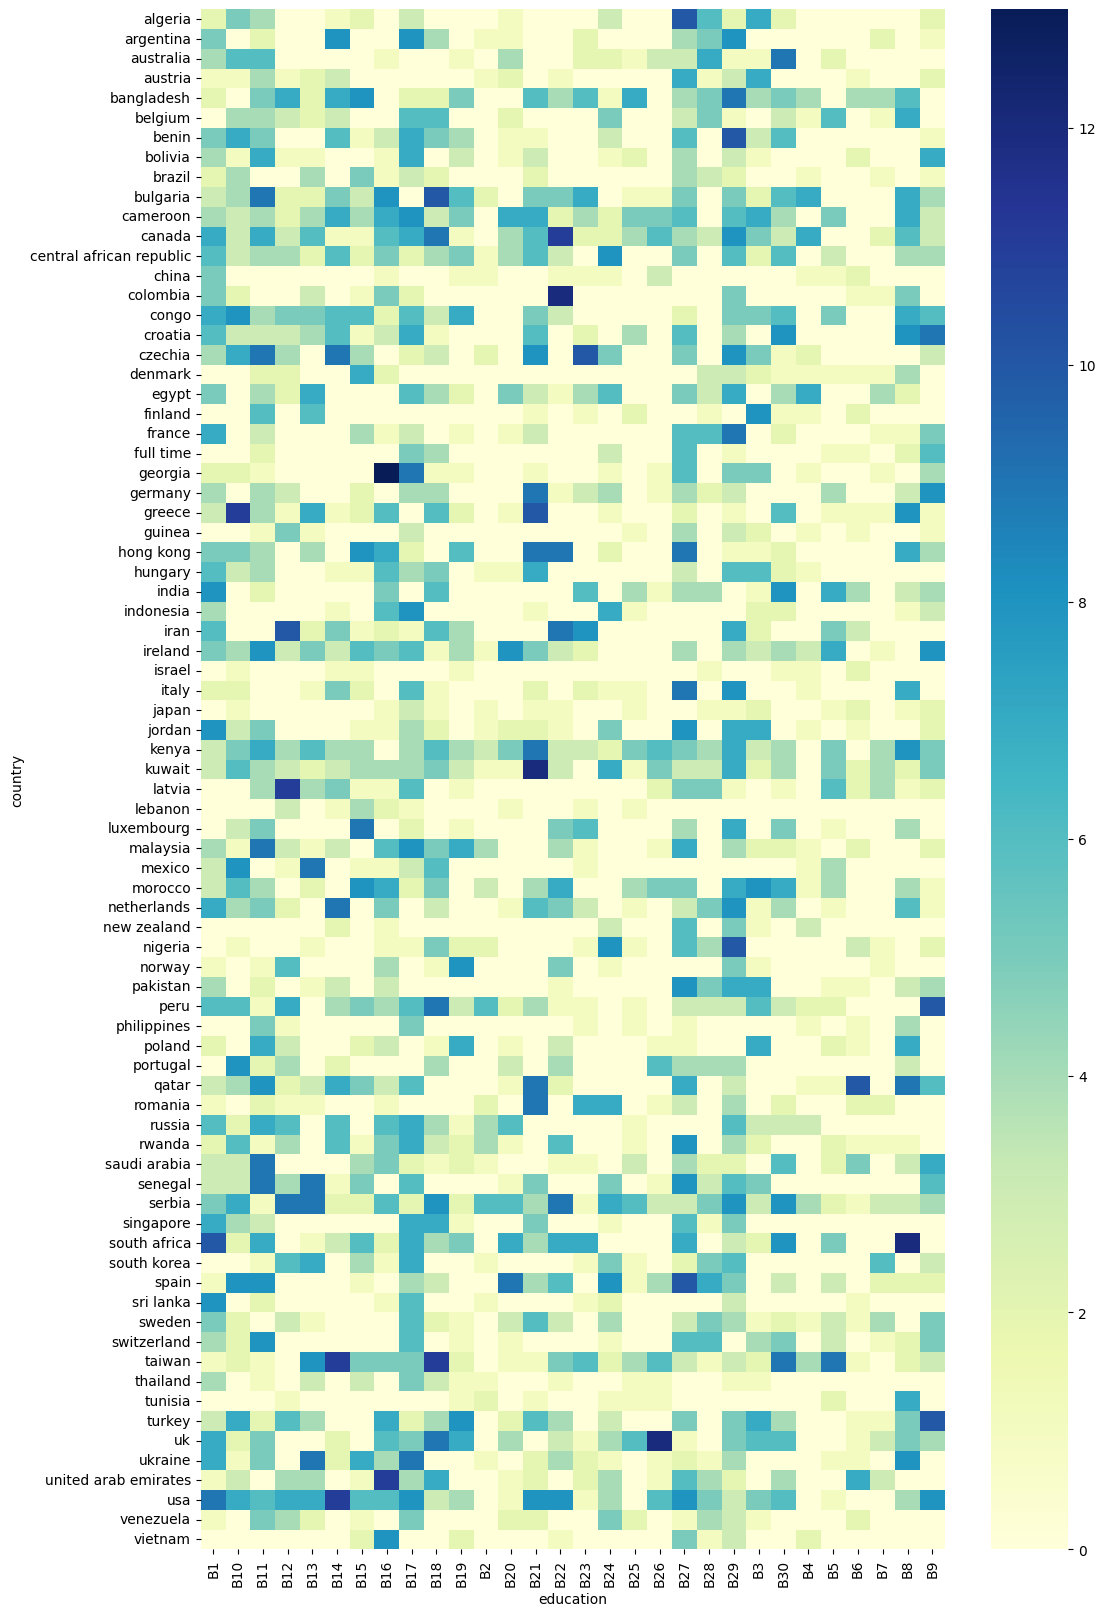

In [10]:
plt.figure(figsize=(12, 20))
sns.heatmap(ob_pivot, annot=False, cmap='YlGnBu', fmt='g', cbar=True) # YlGnBu # viridis
plt.show()

In [11]:
ob_pivot[ob_pivot > 8].stack().reset_index()

,country,education,0
0,algeria,B27,10.0
1,australia,B30,9.0
2,bangladesh,B29,9.0
3,benin,B29,10.0
4,bulgaria,B11,9.0
...,...,...,...
56,ukraine,B13,9.0
57,ukraine,B17,9.0
58,united arab emirates,B16,11.0
59,usa,B1,9.0


In [12]:
# Then, we move to the first call
call_pivot = all_episodes.pivot_table(index='country', columns='education', values='first_call', aggfunc='sum')

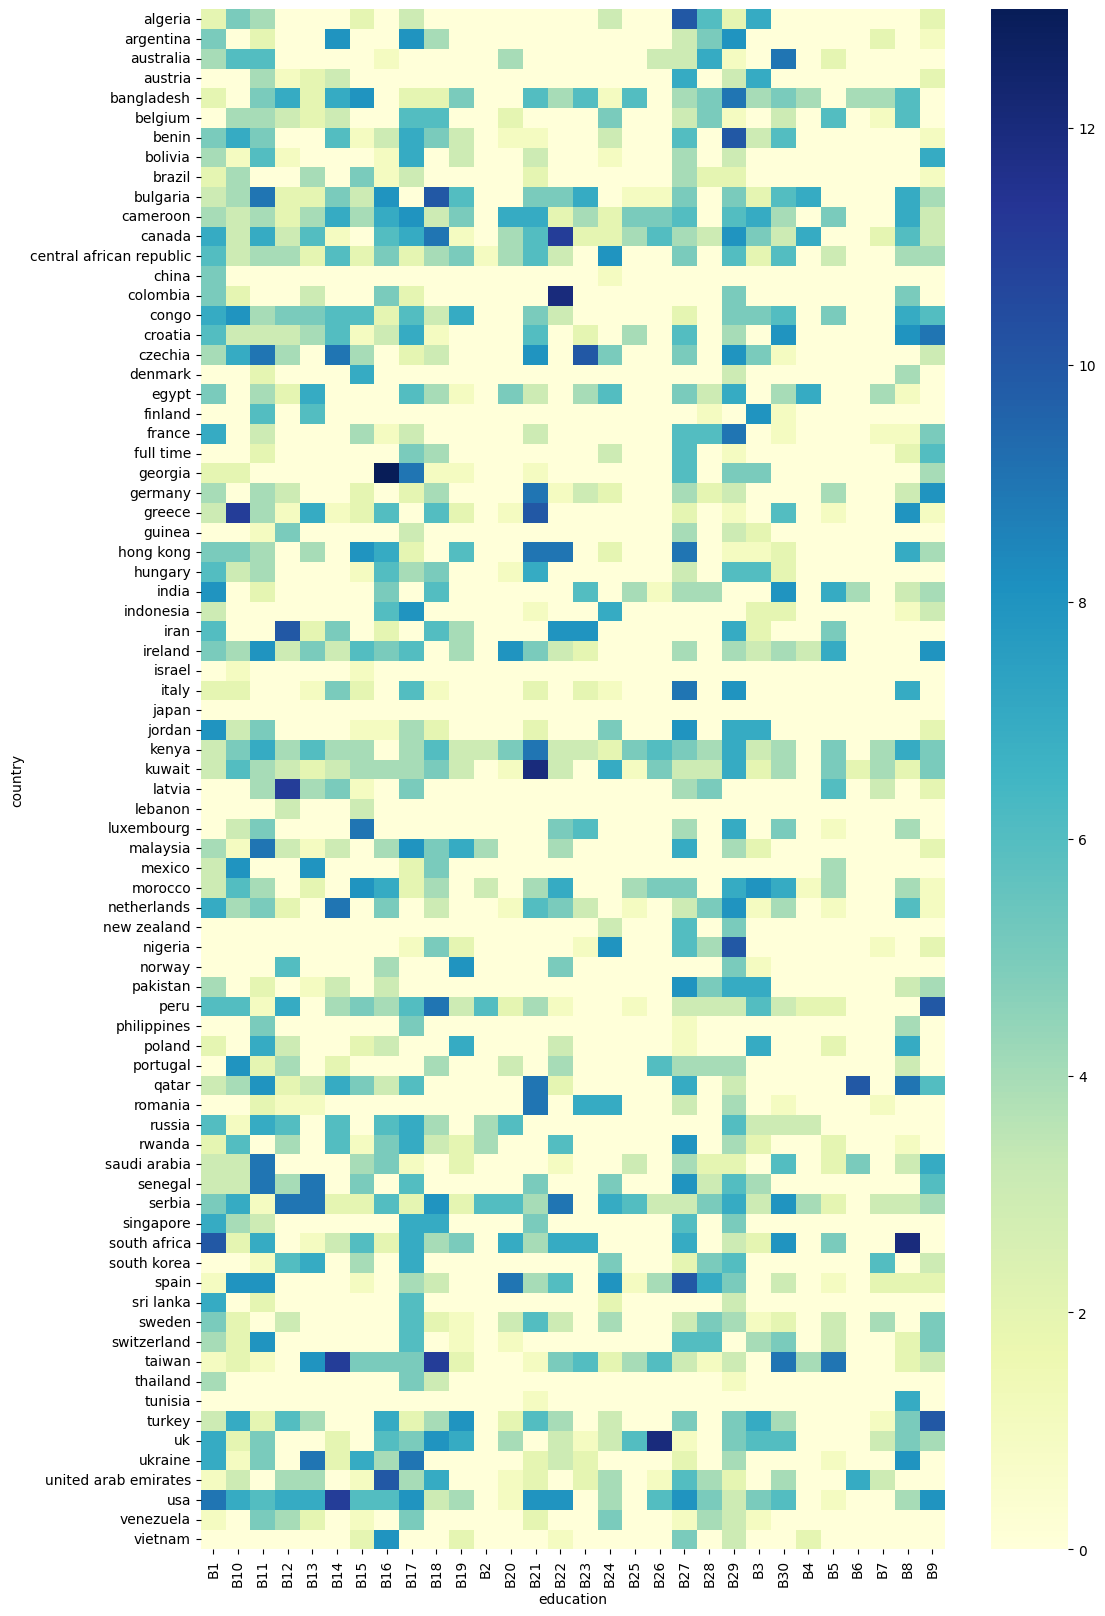

In [13]:
plt.figure(figsize=(12, 20))
sns.heatmap(call_pivot, annot=False, cmap='YlGnBu', fmt='g', cbar=True) # YlGnBu # viridis
plt.show()

In [14]:
call_pivot[call_pivot > 6].stack().reset_index()

,country,education,0
0,algeria,B27,10.0
1,algeria,B3,7.0
2,argentina,B14,8.0
3,argentina,B17,8.0
4,argentina,B29,8.0
...,...,...,...
212,usa,B21,8.0
213,usa,B22,8.0
214,usa,B27,8.0
215,usa,B9,8.0


In [15]:
# Let's start checking when the OnBoarding started
sub_pivot = all_episodes.pivot_table(index='country', columns='education', values='sub', aggfunc='sum')

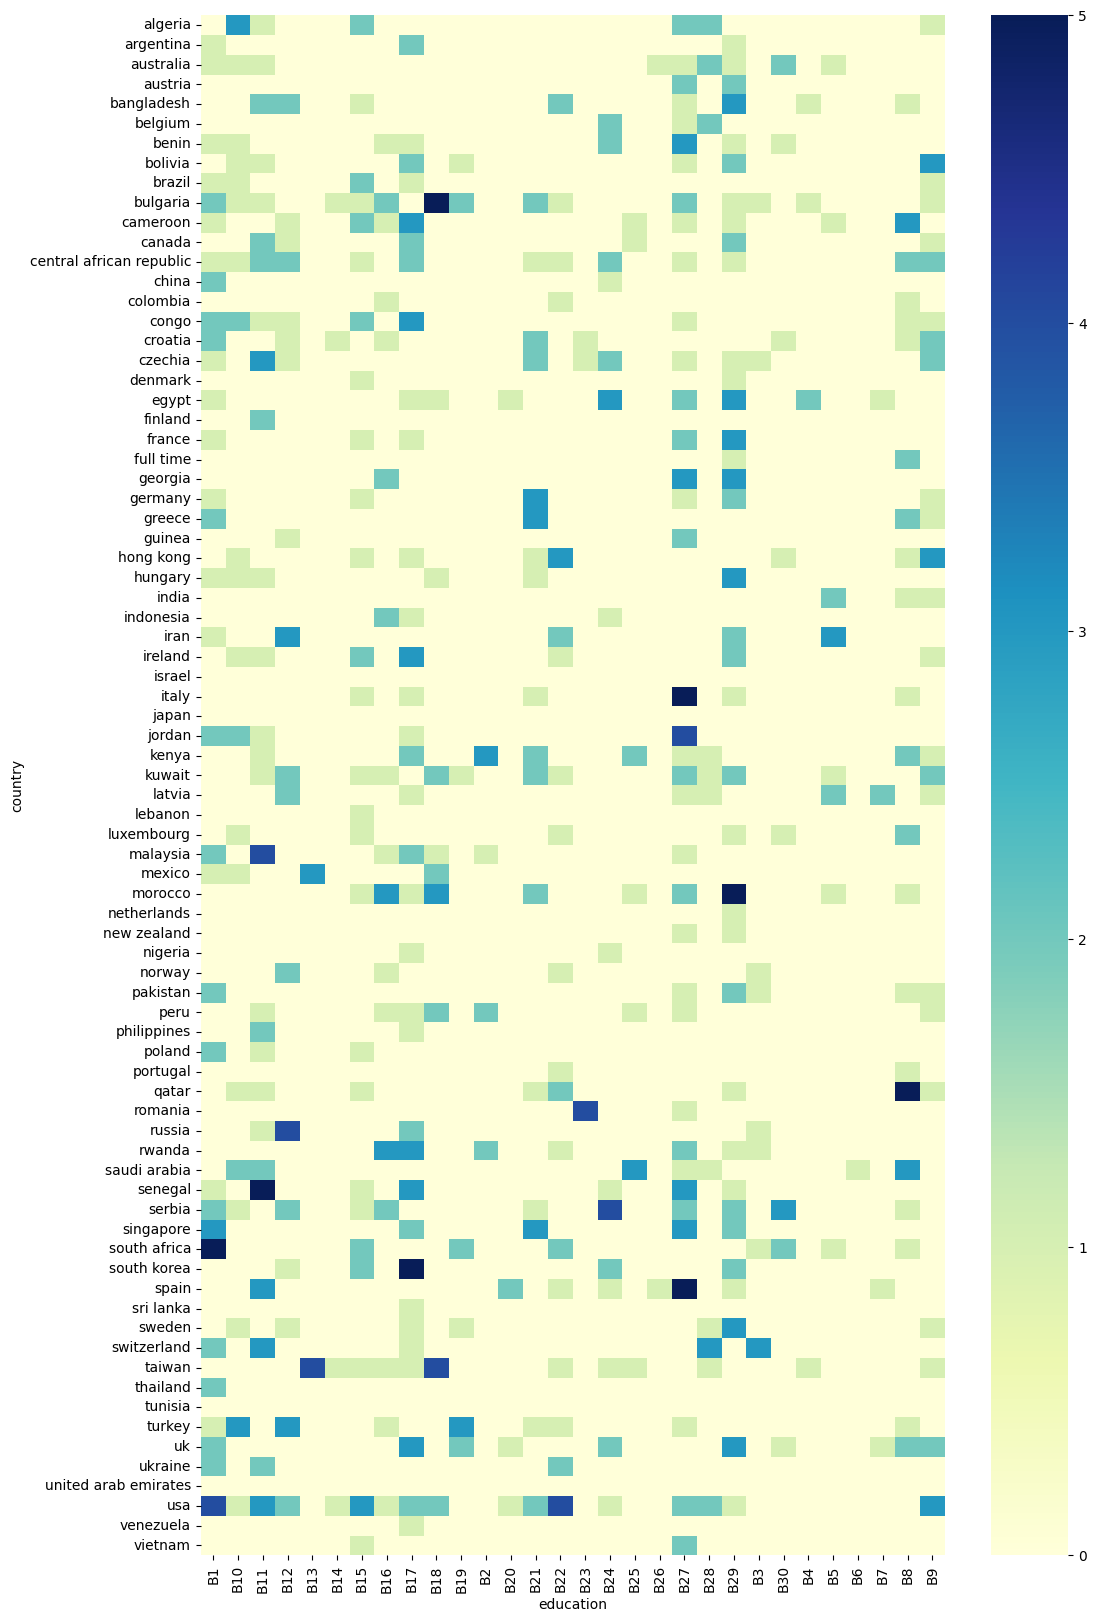

In [16]:
plt.figure(figsize=(12, 20))
sns.heatmap(sub_pivot, annot=False, cmap='YlGnBu', fmt='g', cbar=True) # YlGnBu # viridis
plt.show()

In [17]:
sub_pivot[sub_pivot > 3].stack().reset_index()

,country,education,0
0,bulgaria,B18,5.0
1,italy,B27,5.0
2,jordan,B27,4.0
3,malaysia,B11,4.0
4,morocco,B29,5.0
5,qatar,B8,5.0
6,romania,B23,4.0
7,russia,B12,4.0
8,senegal,B11,5.0
9,serbia,B24,4.0


Selecting the best combinations just based on the subscriptions might not be the best choice, given the low subscription rate.

It could be more meaningful to consider the best combinations for the first call schedule.

These total 217 combinations, which is a fraction of the 2340 original combinations.

# Information extraction - Best OB order

In [26]:
(ob_steps == 6).sum().sum()

50

In [38]:
print("STATISTICS OF THE OBSERVED DATA:")
print(f'Rate of started onboardings: {ob_started_ss.sum() / ob_started_ss.shape[0] * 100 :.2f} %')
print(f'Rate of first calls: {(ob_steps == 3).sum().sum() / ob_steps.shape[0] * 100 :.2f} %')
print(f'Rate of SUBSCRIPTIONS: {(ob_steps == 6).sum().sum() / ob_steps.shape[0] * 100 :.2f} %')
print('\n')
print("STATISTICS OF THE GENERATED DATA:")
print(f'Rate of started onboardings: {all_episodes.ob_started.sum() / all_episodes.shape[0] * 100 :.2f} %')
print(f'Rate of first calls: {all_episodes.first_call.sum() / all_episodes.shape[0] * 100 :.2f} %')
print(f'Rate of SUBSCRIPTIONS: {all_episodes["sub"].sum() / all_episodes.shape[0] * 100 :.2f} %')

STATISTICS OF THE OBSERVED DATA:
Rate of started onboardings: 5.94 %
Rate of first calls: 3.99 %
Rate of SUBSCRIPTIONS: 0.45 %


STATISTICS OF THE GENERATED DATA:
Rate of started onboardings: 10.09 %
Rate of first calls: 9.42 %
Rate of SUBSCRIPTIONS: 1.42 %


In [ ]:
all_episodes['ob_steps'].value_counts()

As we can clearly see from the value counts, the best way to get a subscription is:
1. Schedule the first call
2. Share the platform sign up link
3. Assign an Account Manager
4. Finalize the subscription

This means that the demo and the customer questionnaire **should not** be included in the onboarding process.

For example, the customer feedback could be collected after the subscription.

# Run with best combinations only

let's test our model on the best country-education combinations only, to understand the full scale of the improvement brought by it.

In [18]:
best_combo = call_pivot[call_pivot > 6].stack().reset_index()

In [27]:
num_episodes = 100

keys_names = ['country', 'education', 'n_calls', 'ob_started', 'first_call', 'sub', 'ob_steps']
all_episodes = pd.DataFrame(columns=keys_names)

# some tracking matrices
total_reward = 0
avg_reward = []
total_sub = 0
sub_rate = []
total_call = 0
call_rate = []
total_ob = 0
ob_rate = []

q_network =  QNetwork(input_size, output_size, seed=42) #.to(device)
q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{50000}.pth', map_location=torch.device('cpu')))
# q_network.load_state_dict(torch.load(f'/content/gdrive/MyDrive/P7_files/q_network_{50000}.pth'))

# Initialize the empty vectors for country and education
empty_country = country_ss.loc[2].copy()
empty_country['Country_austria'] = 0
empty_education = education_ss.iloc[0].copy()
empty_education['Education_B27'] = 0

# Iterate through each best combination
for i in range(best_combo.shape[0]):

  country = empty_country.copy()
  country[f'Country_{best_combo.iloc[i, 0]}'] = 1
  education = empty_education.copy()
  education[f'Education_{best_combo.iloc[i, 1]}'] = 1


  for episode in range(num_episodes):

    current_episode = {key: None for key in keys_names}

    # Assigned the country and education
    current_episode['country'] = best_combo.iloc[i, 0]
    current_episode['education'] = best_combo.iloc[i, 1]

    # The remaining states components are all going to be set to Zero:
    # Customer was never contacted and the OB did not start
    remaining_ss = np.zeros((1, 50))
    state = np.concatenate((country.values.reshape((1,-1)), education.values.reshape((1,-1)), remaining_ss), axis=1)

    steps_done = []
    episode_reward = 0
    done = False
    reward_call_done = False
    reward_ob_done = False
    am_assigned = False

    while not done:
      #############################################################
      ####      SELECT THE ACTION BASED ON A GREEDY POLICY     ####
      #############################################################

      q_values = q_network(torch.tensor(state, dtype=torch.float32).to(device))
      action = np.argmax(q_values.detach().numpy()) + 1

      ################################################################
      ####  FROM CURRENT STATE AND ACTION, OBSERVE THE NEXT STATE ####
      ################################################################

      next_state, steps_done, trans_prob, done = take_step(state.copy(), action, steps_done)

      #########################################################
      ####  COMPUTE THE REWARDS BASED ON THE NEXT STATE    ####
      #########################################################

      # Remember that the variable steps_done has already been updated, so it reflects the next state
      reward = 0

      # Check if the Account manager has been assigned
      if np.isin(5, steps_done):
        am_assigned = True

      # If in the state there is -2, it means that the AM was assigned twice
      # we want to highly discourage this behavior
      if np.isin(-2, steps_done):
        reward += stop_am_double

      # Else If the ob_steps (i.e. the last 6 values of the state) contain at any point the value 6, that means that the subscription happened
      elif np.isin(6, steps_done):
        current_episode['sub'] = 1
        if am_assigned:
          reward += reward_sub_am
        else:
          reward += reward_sub
        total_sub += 1

      # Else if there is a -1 at any point in the ob_steps, it means that the OB did not succeed
      elif np.isin(-1, steps_done):
        if am_assigned:
          reward += stop_ob_am
        else:
          reward += stop_ob

      # If the first call happened (step number 3), then get the call reward
      # Note that this reward can be assigned once, so we need to keep track of it
      if np.isin(3, steps_done) and not reward_call_done:
        current_episode['first_call'] = 1
        reward += reward_call
        reward_call_done = True
        total_call += 1
      # If it's the first time the OB has started, then assign the appropriate reward
      if steps_done != [] and not reward_ob_done:
        current_episode['ob_started'] = 1
        reward += reward_ob
        reward_ob_done = True
        total_ob += 1

      #########################################################
      ####               MOVE TO THE NEXT STATE            ####
      #########################################################
      state = next_state
      episode_reward += reward

    #########################################################
    ####                  SAVE THE EPISODE               ####
    #########################################################
    current_episode['n_calls'] = state[0, -50]
    current_episode['ob_steps'] = str(steps_done)
    all_episodes = pd.concat([all_episodes, pd.DataFrame(current_episode, index=[episode])])
    total_reward += episode_reward

  # END OF THE EPISODES OF A GIVEN COUNTRY-EDUCATION COMBO: PRINT THE RESULTS
  # Get the average reward & save it
  avg_rew = total_reward / 100
  avg_reward.append(avg_rew)

  # Get the subscription rate
  avg_sub = total_sub / 100
  sub_rate.append(avg_sub)

  # Get the call rate
  avg_call = total_call / 100
  call_rate.append(avg_call)

  # Get the subscription rate
  avg_ob = total_ob / 100
  ob_rate.append(avg_ob)

  # Reset & print a recap
  total_reward = 0
  total_sub = 0
  total_call = 0
  total_ob = 0
  print(f"\n####################################\nEND OF RUN FOR COMBO: {best_combo.iloc[i, 0]} & {best_combo.iloc[i, 1]} ")
  print(f"The observed average reward is: {avg_rew}")
  print(f"The observed subscription rate is: {avg_sub}")
  print(f"The observed call rate is: {avg_call}")
  print(f"The observed onboarding rate is: {avg_ob}")

# Save the episodes DF
with open('/content/gdrive/MyDrive/P7_files/best_all_episodes.pkl', 'wb') as handle:
  pickle.dump(all_episodes, handle)

# Get the average reward & save it
avg_rew = total_reward / 100
avg_reward.append(avg_rew)
with open('/content/gdrive/MyDrive/P7_files/best_avg_reward.pkl', 'wb') as handle:
  pickle.dump(avg_reward, handle)

# Get the subscription rate
avg_sub = total_sub / 100
sub_rate.append(avg_sub)
with open('/content/gdrive/MyDrive/P7_files/best_sub_rate.pkl', 'wb') as handle:
  pickle.dump(sub_rate, handle)

# Get the call rate
avg_call = total_call / 100
call_rate.append(avg_call)
with open('/content/gdrive/MyDrive/P7_files/best_call_rate.pkl', 'wb') as handle:
  pickle.dump(call_rate, handle)

# Get the subscription rate
avg_ob = total_ob / 100
ob_rate.append(avg_ob)
with open('/content/gdrive/MyDrive/P7_files/best_ob_rate.pkl', 'wb') as handle:
  pickle.dump(ob_rate, handle)


####################################
END OF RUN FOR COMBO: algeria & B27 
The observed average reward is: 0.6839999999999999
The observed subscription rate is: 0.09
The observed call rate is: 0.24
The observed onboarding rate is: 0.24

####################################
END OF RUN FOR COMBO: algeria & B3 
The observed average reward is: 0.07199999999999998
The observed subscription rate is: 0.0
The observed call rate is: 0.12
The observed onboarding rate is: 0.12

####################################
END OF RUN FOR COMBO: argentina & B14 
The observed average reward is: 0.11399999999999996
The observed subscription rate is: 0.0
The observed call rate is: 0.19
The observed onboarding rate is: 0.19

####################################
END OF RUN FOR COMBO: argentina & B17 
The observed average reward is: 0.18800000000000006
The observed subscription rate is: 0.02
The observed call rate is: 0.14
The observed onboarding rate is: 0.14

####################################
END OF RUN FOR

In [28]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 218)), y=ob_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 218)), y=np.ones((217,)) * (ob_started_ss.sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch OnBoarding rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='OB rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [29]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 218)), y=call_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 218)), y=np.ones((217,)) * ((ob_steps == 3).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch Call rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Call rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [30]:
# Create a trace for the line plot
trace_1 = go.Scatter(x=list(range(1, 218)), y=sub_rate, mode='lines')

trace_2 = go.Scatter(x=list(range(1, 218)), y=np.ones((217,)) * ((ob_steps == 6).sum().sum() / ob_steps.shape[0]), mode='lines', line=dict(color='red'))

# Create the layout for the plot
layout = go.Layout(title='Epoch subscription rate over training', xaxis=dict(title='Episodes (x1000)'), yaxis=dict(title='Sub rate'))

# Create the figure
fig = go.Figure(data=[trace_1, trace_2], layout=layout)

# Show the plot
fig.show()

In [32]:
print("STATISTICS OF THE OBSERVED DATA:")
print(f'Rate of started onboardings: {ob_started_ss.sum() / ob_started_ss.shape[0] * 100 :.2f} %')
print(f'Rate of first calls: {(ob_steps == 3).sum().sum() / ob_steps.shape[0] * 100 :.2f} %')
print(f'Rate of SUBSCRIPTIONS: {(ob_steps == 6).sum().sum() / ob_steps.shape[0] * 100 :.2f} %')
print('\n')
print("STATISTICS OF THE BEST COMBO DATA:")
print(f'Rate of started onboardings: {all_episodes.ob_started.sum() / all_episodes.shape[0] * 100 :.2f} %')
print(f'Rate of first calls: {all_episodes.first_call.sum() / all_episodes.shape[0] * 100 :.2f} %')
print(f'Rate of SUBSCRIPTIONS: {all_episodes["sub"].sum() / all_episodes.shape[0] * 100 :.2f} %')

STATISTICS OF THE OBSERVED DATA:
Rate of started onboardings: 5.94 %
Rate of first calls: 3.99 %
Rate of SUBSCRIPTIONS: 0.45 %


STATISTICS OF THE BEST COMBO DATA:
Rate of started onboardings: 23.00 %
Rate of first calls: 22.80 %
Rate of SUBSCRIPTIONS: 3.89 %


# Conclusions

Thanks to our trained model, we managed to

1. **Identify the candidates most likely to subscribe**
2. **Identify the best order for the onboarding steps**

The optimal policy, applied to all the data sample (i.e. to all the country-education combinations, not just the best ones) already showed impressive subscription growth:
- The rate of first call performed passed from 3.99% to 9.42%, which is a **236% increase**
- The rate of subscription passed from 0.45 to 1.42%, which is a **316% increase**

If we look at the optimal policy applied to the **best combinations** of Country and Education, we then see more stunning results:
- The rate of first call performed is 22.80%, which is a **571% increase**
- The rate of subscription is 3.89%, which is a **864% increase**